## 00_Liberaries

In [1]:
import pandas as pd
import numpy as np
import lasio


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble

#outlier detection
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import f1_score, recall_score, mean_squared_error, r2_score, precision_score, classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree, export_text
from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

## 01_Functions

In [2]:
def create_las_file(predict_curve:list, md_depth:list,wellName: str):   
    filename_suffix='.las'
    las = lasio.LASFile()
    las.well.WELL=wellName
    las.append_curve('DEPT',md_depth, unit='ft')
    las.append_curve('DT_Pred', predict_curve ,descr='predicted_DT')
    las.write(wellName+ filename_suffix, version=2)

In [3]:
def create_well_log_plot(well):
   
    fig, ax = plt.subplots(figsize=(12, 15))
    #Set up the plot axes
    ax_gr = plt.subplot2grid((1, 6), (0, 0), rowspan=1, colspan=1)
    ax_rhob = plt.subplot2grid((1, 6), (0, 1),rowspan=1,colspan=1,sharey=ax_gr)
    ax_dt = plt.subplot2grid((1, 6), (0, 2),rowspan=1,colspan=1,sharey=ax_gr)
    
    ax_nphi = ax_rhob.twiny()
    ax_pef = plt.subplot2grid((1, 6), (0, 3),rowspan=1,colspan=1,sharey=ax_gr)
    
    # Gamma Ray track
    ax_gr.plot(well["GR"], well.MD, color="green", linewidth=1.5)
    ax_gr.set_xlabel("GR")
    ax_gr.xaxis.label.set_color("green")
    ax_gr.set_xlim(0, 200)
    ax_gr.set_ylabel("Depth (MDft)")
    ax_gr.tick_params(axis='x', colors="green")
    ax_gr.spines["top"].set_edgecolor("green")
    ax_gr.title.set_color('green')
    ax_gr.set_xticks(np.arange(0, 200, 50))

    # Density track
    ax_rhob.plot(well["RHOB"], well.MD, color="red", linewidth=1.5)
    ax_rhob.set_xlabel("RHOB")
    ax_rhob.set_xlim(1.95, 2.95)
    ax_rhob.xaxis.label.set_color("red")
    ax_rhob.tick_params(axis='x', colors="red")
    ax_rhob.spines["top"].set_edgecolor("red")
    #ax_rhob.set_xticks([1.95,2.15,2.35,2.55,2.75, 2.95])

    # Neutron track placed ontop of density track
    ax_nphi.plot(well["NPHI"], well.MD, color="blue", linewidth=1.5)
    ax_nphi.set_xlabel('NPHI')
    ax_nphi.xaxis.label.set_color("blue")
    ax_nphi.set_xlim(0.45, -0.15)
    ax_nphi.tick_params(axis='x', colors="blue")
    ax_nphi.spines["top"].set_position(("axes", 1.08))
    ax_nphi.spines["top"].set_edgecolor("blue")
    #ax_nphi.set_xticks([0.45,0.33,0.21,0.15,0.09,-0.03, -0.15])

    # DT track
    ax_dt.plot(well["DT"], well.MD, color="brown", linewidth=1.5)
    ax_dt.set_xlabel("DT")
    ax_dt.xaxis.label.set_color("brown")
    ax_dt.set_xlim(0, 150)
    ax_dt.tick_params(axis='x', colors="brown")
    ax_dt.spines["top"].set_edgecolor("brown")
    ax_dt.title.set_color('brown')
    ax_dt.set_xticks(np.arange(0, 150, 50))

    # pef_final track
    ax_pef.plot(well["PEF"],
                      well.MD,
                      color="darkred",
                      linewidth=1.5)
    ax_pef.set_xlabel("pef")
    ax_pef.xaxis.label.set_color("darkred")
    ax_pef.set_xlim(0, 20)
    ax_pef.tick_params(axis='x', colors="darkred")
    ax_pef.spines["top"].set_edgecolor("darkred")
    ax_pef.title.set_color('darkred')
    
    # Common functions for setting up the plot can be extracted into
    # a for loop. This saves repeating code.
    for ax in [ax_gr, ax_rhob, ax_dt, ax_pef]:
        ax.set_ylim(well.MD.max(), well.MD.min())

        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))

    for ax in [ax_rhob, ax_dt, ax_pef]:
        plt.setp(ax.get_yticklabels(), visible=False)

    fig.suptitle('Well: %s' % well.iloc[0]['wellName'], fontsize=16, y=1)
    fig.subplots_adjust(wspace=0)

## 02_EDA

In [104]:
main_df=pd.read_csv('./sonic_wells_data/df_for_model.csv')

In [105]:
main_df.shape

(70911, 8)

In [106]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70911 entries, 0 to 70910
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MD        70911 non-null  float64
 1   DT        44611 non-null  float64
 2   GR        45426 non-null  float64
 3   NPHI      36430 non-null  float64
 4   PEF       29587 non-null  float64
 5   RD        19139 non-null  float64
 6   RHOB      36557 non-null  float64
 7   wellName  70911 non-null  object 
dtypes: float64(7), object(1)
memory usage: 4.3+ MB


In [107]:
main_df.dropna(axis=0, inplace=True)
main_df.reset_index(inplace=True)
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17450 entries, 0 to 17449
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     17450 non-null  int64  
 1   MD        17450 non-null  float64
 2   DT        17450 non-null  float64
 3   GR        17450 non-null  float64
 4   NPHI      17450 non-null  float64
 5   PEF       17450 non-null  float64
 6   RD        17450 non-null  float64
 7   RHOB      17450 non-null  float64
 8   wellName  17450 non-null  object 
dtypes: float64(7), int64(1), object(1)
memory usage: 1.2+ MB


In [108]:
main_df['wellName']=main_df['wellName'].astype('category')
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17450 entries, 0 to 17449
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   index     17450 non-null  int64   
 1   MD        17450 non-null  float64 
 2   DT        17450 non-null  float64 
 3   GR        17450 non-null  float64 
 4   NPHI      17450 non-null  float64 
 5   PEF       17450 non-null  float64 
 6   RD        17450 non-null  float64 
 7   RHOB      17450 non-null  float64 
 8   wellName  17450 non-null  category
dtypes: category(1), float64(7), int64(1)
memory usage: 1.1 MB


In [39]:
main_df

index       MD             DT            GR          NPHI  \
0      13286   6643.0  177.764000000  29.973600000  0.4900000000   
1      13287   6643.5   98.444000000  32.972400000  0.4590000000   
2      13288   6644.0   98.633000000  46.114200000  0.4610000000   
3      13289   6644.5  104.232000000  56.622600000  0.4340000000   
4      13290   6645.0  118.779000000  61.119000000  0.3450000000   
...      ...      ...            ...           ...           ...   
17445  69147  11031.5   68.750297546  39.419898987  0.2630000114   
17446  69148  11032.0   68.750297546  39.419898987  0.2630000114   
17447  69149  11032.5   68.750297546  39.419898987  0.2630000114   
17448  69150  11033.0   68.750297546  39.419898987  0.2630000114   
17449  69151  11033.5   68.750297546  39.419898987  0.2630000114   

                 PEF            RD          RHOB wellName  
0      42.5740000000  0.5419999957  2.0910000000   well_1  
1      19.5680000000  0.3499999940  2.4960000000   well_1  
2      13.8510000000  0.2329999954  2.5390000000   well_1  
3       9.2390000000  0.1469999999  2.2640000000   well_1  
4       7.2760000000  0.1099999994  2.2570000000   well_1  
...              ...           ...           ...      ...  
17445   4.1895518303  0.7548000216  2.0139031410   well_3  
17446   4.1954121590  0.7550999522  2.0148868561   well_3  
17447   4.2011322975  0.7553988099  2.0158813000   well_3  
17448   4.1402673721  0.7555977702  2.0330317020   well_3  
17449   4.0786161423  0.7555999756  2.0503728390   well_3  

[17450 rows x 9 columns]

In [109]:
main_df.describe()

index                MD                DT                GR  \
count  17450.0000000000  17450.0000000000  17450.0000000000  17450.0000000000   
mean   34250.4990257880   9719.0199140401     77.6415187724     54.4180719901   
std    20554.6270450197   1375.7644095779     14.4927315306     29.0893577143   
min    13286.0000000000   6643.0000000000     16.8100000000      3.0868885517   
25%    17648.2500000000   8824.1250000000     67.3739395140     39.4198989870   
50%    22217.5000000000   9997.7500000000     74.8650000000     51.9095000000   
75%    45291.7500000000  10810.3750000000     85.4817945710     64.0250000000   
max    69151.0000000000  11947.0000000000    205.6930000000    346.2270000000   

                   NPHI               PEF                RD              RHOB  
count  17450.0000000000  17450.0000000000  17450.0000000000  17450.0000000000  
mean       0.1658830087      4.8300373249     52.7243113023      2.5402802859  
std        0.0825781759      1.5856271321    255.1452761734      0.1603508604  
min       -0.0162984260      1.8822070360      0.1099999994      1.9523283243  
25%        0.1086510625      3.7749925613      1.3542178182      2.4650000000  
50%        0.1530000000      4.9845000000      3.1729101649      2.5460000000  
75%        0.2150000000      5.6441375000      8.4337499027      2.6063907146  
max        3.1877765656     42.5740000000   1950.0000000000      4.6287999153

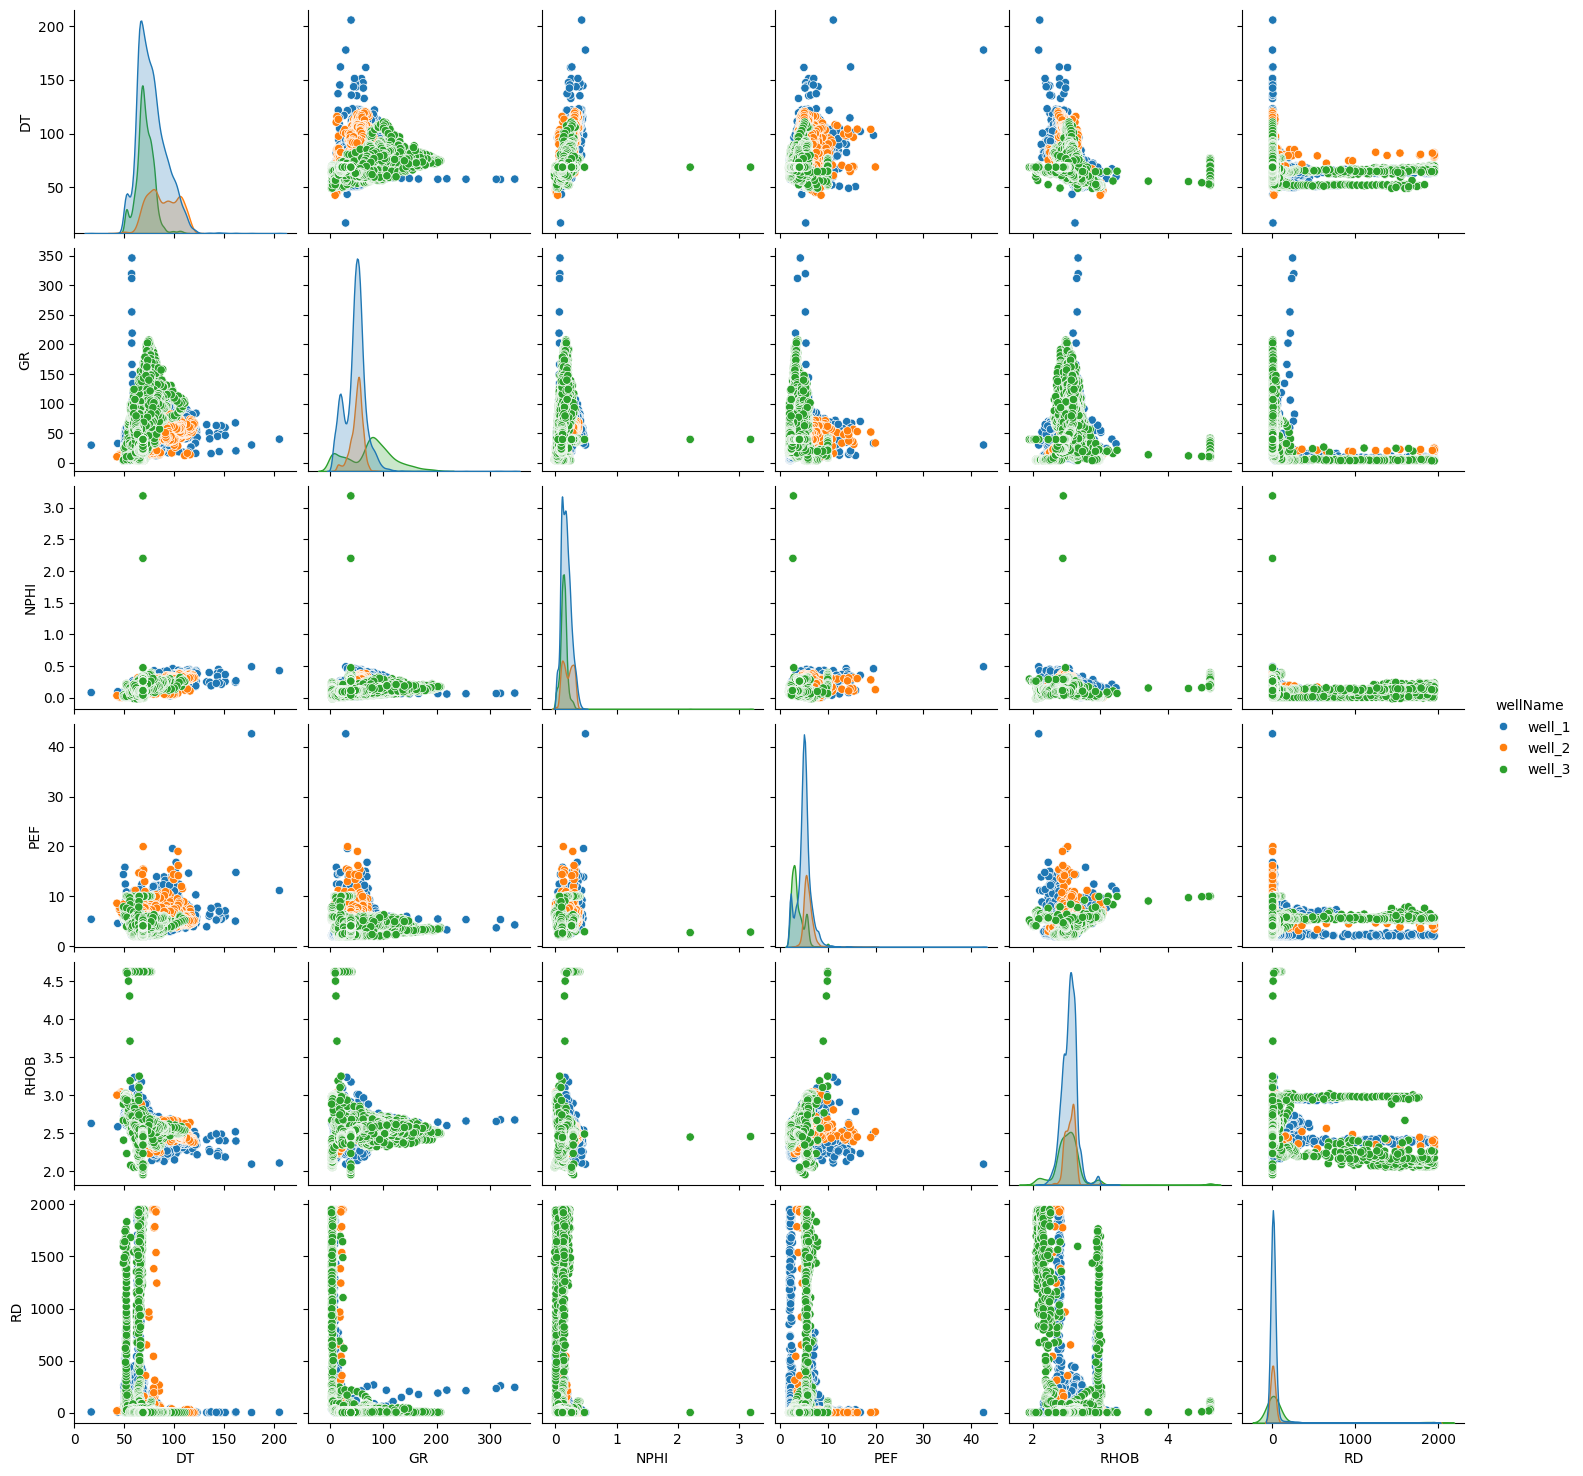

In [16]:
sns.pairplot(main_df[['DT', 'GR', 'NPHI', 'PEF','RHOB','RD', 'wellName']],
             hue='wellName',
             diag_kind = 'kde',
             )

<Axes: >

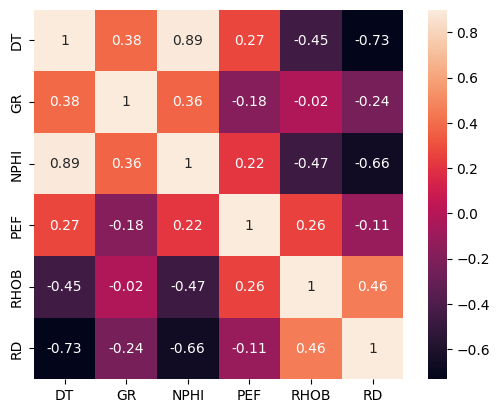

In [21]:

sns.heatmap(main_df[['DT', 'GR', 'NPHI', 'PEF','RHOB','RD']].corr(method = 'spearman')
            ,annot=True,   vmax=0.9, square=True)

### Outliers Detection

In [83]:
main_df_re_out=main_df[['DT', 'GR', 'NPHI', 'PEF','RHOB']]

In [84]:
main_df_re_out

DT            GR          NPHI            PEF          RHOB
0      177.764000000  29.973600000  0.4900000000  42.5740000000  2.0910000000
1       98.444000000  32.972400000  0.4590000000  19.5680000000  2.4960000000
2       98.633000000  46.114200000  0.4610000000  13.8510000000  2.5390000000
3      104.232000000  56.622600000  0.4340000000   9.2390000000  2.2640000000
4      118.779000000  61.119000000  0.3450000000   7.2760000000  2.2570000000
...              ...           ...           ...            ...           ...
17445   68.750297546  39.419898987  0.2630000114   4.1895518303  2.0139031410
17446   68.750297546  39.419898987  0.2630000114   4.1954121590  2.0148868561
17447   68.750297546  39.419898987  0.2630000114   4.2011322975  2.0158813000
17448   68.750297546  39.419898987  0.2630000114   4.1402673721  2.0330317020
17449   68.750297546  39.419898987  0.2630000114   4.0786161423  2.0503728390

[17450 rows x 5 columns]

In [85]:
# Method 1: Standard Deviation Method (traditional)
well_train_std = main_df_re_out[np.abs(main_df_re_out - main_df_re_out.mean()) <= (3 * main_df_re_out.std())]
well_train_std = well_train_std.dropna()

# Method 2: Isolation Forest
iso = IsolationForest(contamination=0.05)
yhat = iso.fit_predict(main_df_re_out)
mask = yhat != -1
well_train_iso = main_df_re_out[mask]

# Method 3: Minimum Covariance Determinant
ee = EllipticEnvelope(contamination=0.05)
yhat = ee.fit_predict(main_df_re_out)
mask = yhat != -1
well_train_ee = main_df_re_out[mask]

# Method 4: Local Outlier Factor
lof = LocalOutlierFactor(contamination=0.5)
yhat = lof.fit_predict(main_df_re_out)
mask = yhat != -1
well_train_lof = main_df_re_out[mask]

# Method 5: One-class SVM
svm = OneClassSVM(nu=0.05)
yhat = svm.fit_predict(main_df_re_out)
mask = yhat != -1
well_train_svm = main_df_re_out[mask]

In [86]:
print('Number of points before outliers removed                       :', len(main_df_re_out))
print('Number of points after outliers removed with Standard Deviation:', len(well_train_std))
print('Number of points after outliers removed with Isolation Forest  :', len(well_train_iso))
print('Number of points after outliers removed with Min. Covariance   :', len(well_train_ee))
print('Number of points after outliers removed with Outlier Factor    :', len(well_train_lof))
print('Number of points after outliers removed with One-class SVM     :', len(well_train_svm))

Number of points before outliers removed                       : 17450
Number of points after outliers removed with Standard Deviation: 16912
Number of points after outliers removed with Isolation Forest  : 16577
Number of points after outliers removed with Min. Covariance   : 16577
Number of points after outliers removed with Outlier Factor    : 8725
Number of points after outliers removed with One-class SVM     : 16576


In [29]:
feature_target=['DT', 'GR', 'NPHI', 'PEF','RHOB']

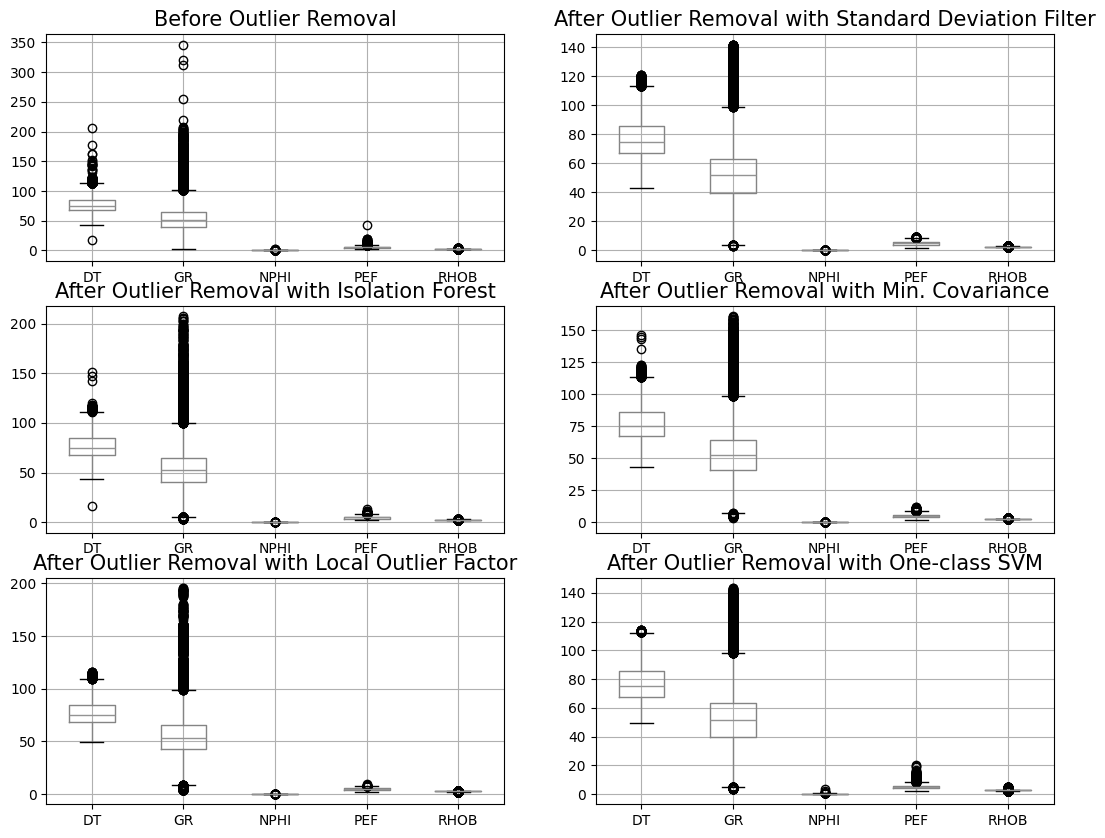

In [88]:
plt.figure(figsize=(13,10))

plt.subplot(3,2,1)
main_df_re_out.boxplot()
plt.title('Before Outlier Removal', size=15)

plt.subplot(3,2,2)
well_train_std[feature_target].boxplot()
plt.title('After Outlier Removal with Standard Deviation Filter', size=15)

plt.subplot(3,2,3)
well_train_iso[feature_target].boxplot()
plt.title('After Outlier Removal with Isolation Forest', size=15)

plt.subplot(3,2,4)
well_train_ee[feature_target].boxplot()
plt.title('After Outlier Removal with Min. Covariance', size=15)

plt.subplot(3,2,5)
well_train_lof[feature_target].boxplot()
plt.title('After Outlier Removal with Local Outlier Factor', size=15)

plt.subplot(3,2,6)
well_train_svm[feature_target].boxplot()
plt.title('After Outlier Removal with One-class SVM', size=15)

#plt.tight_layout(1.7)
plt.show()

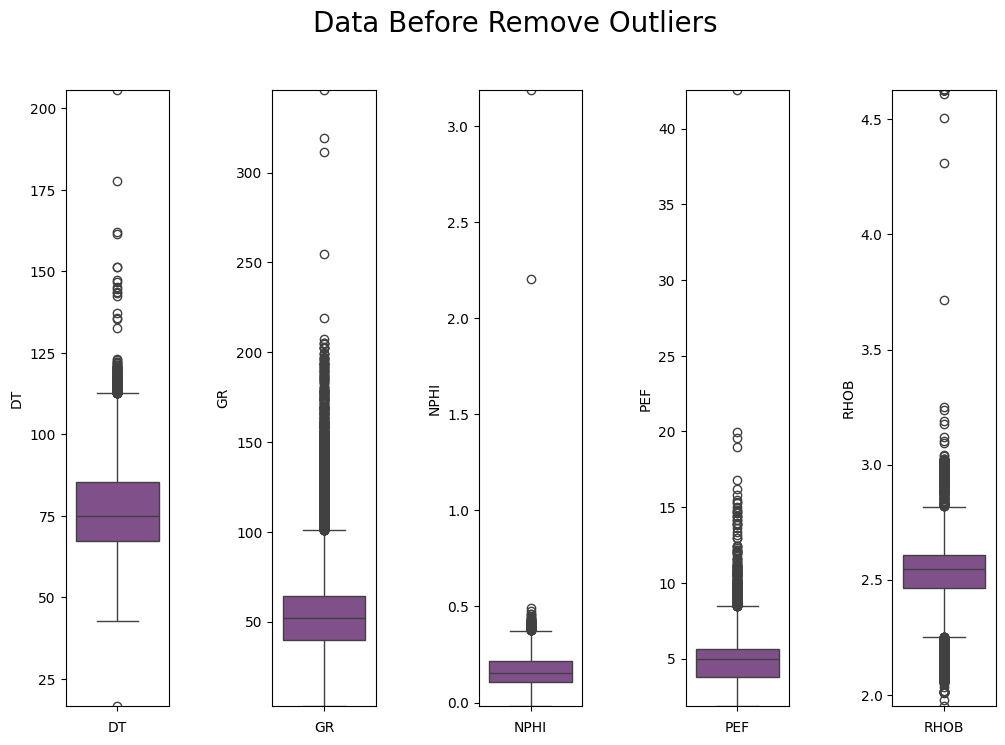

In [92]:
columns = main_df_re_out.columns 
fig, axes = plt.subplots(1, len(columns),figsize=(12,8))
fig.suptitle('Data Before Remove Outliers', fontsize=20)
plt.subplots_adjust(wspace = 1)
for i, col in enumerate(columns):
    ax = sns.boxplot(y=main_df_re_out[col], ax=axes.flatten()[i])
    ax.set_ylim(main_df_re_out[col].min(), main_df_re_out[col].max())
    ax.set_xlabel(col)


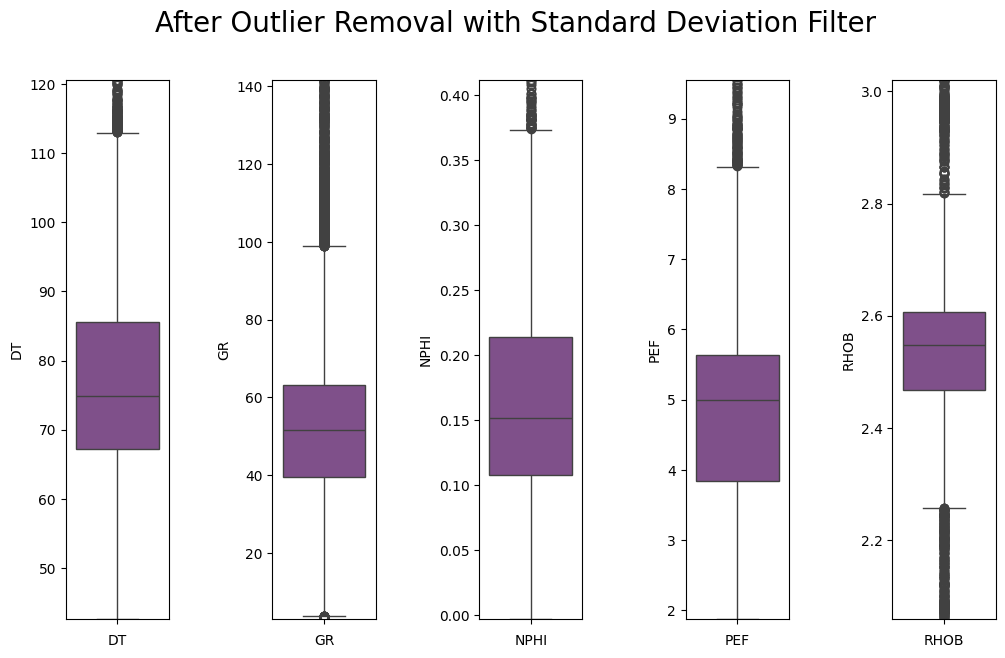

In [93]:
fig, axes = plt.subplots(1, len(columns),figsize=(12,7))
fig.suptitle('After Outlier Removal with Standard Deviation Filter', fontsize=20)
plt.subplots_adjust(wspace = 1)
for i, col in enumerate(columns):
    ax = sns.boxplot(y=well_train_std[col], ax=axes.flatten()[i])
    ax.set_ylim(well_train_std[col].min(), well_train_std[col].max())
    ax.set_xlabel(col)

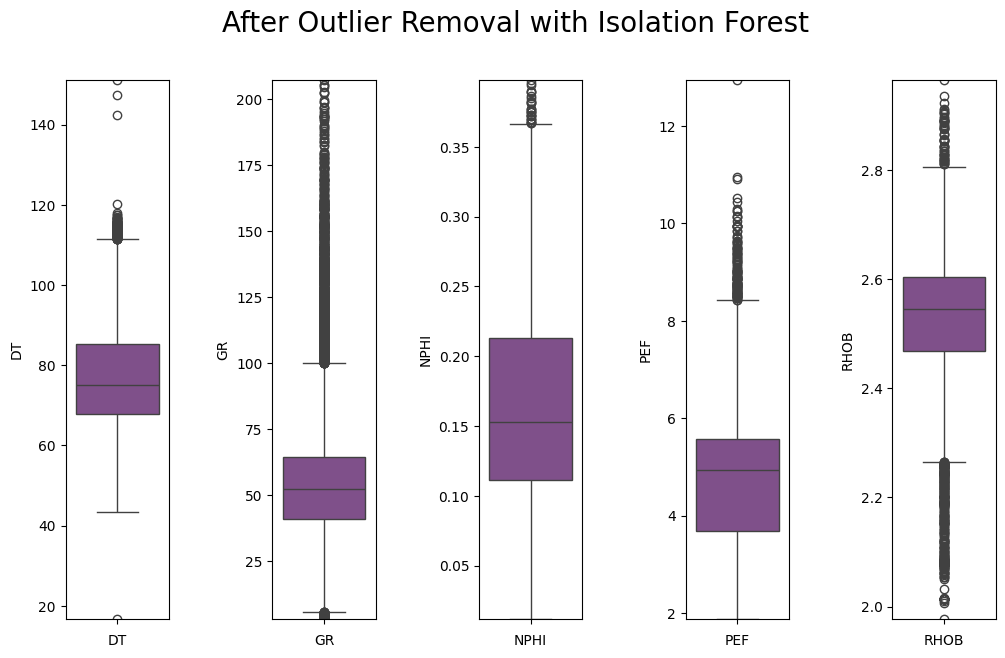

In [94]:
fig, axes = plt.subplots(1, len(columns),figsize=(12,7))
fig.suptitle('After Outlier Removal with Isolation Forest', fontsize=20)
plt.subplots_adjust(wspace = 1)
for i, col in enumerate(columns):
    ax = sns.boxplot(y=well_train_iso[col], ax=axes.flatten()[i])
    ax.set_ylim(well_train_iso[col].min(), well_train_iso[col].max())
    ax.set_xlabel(col)

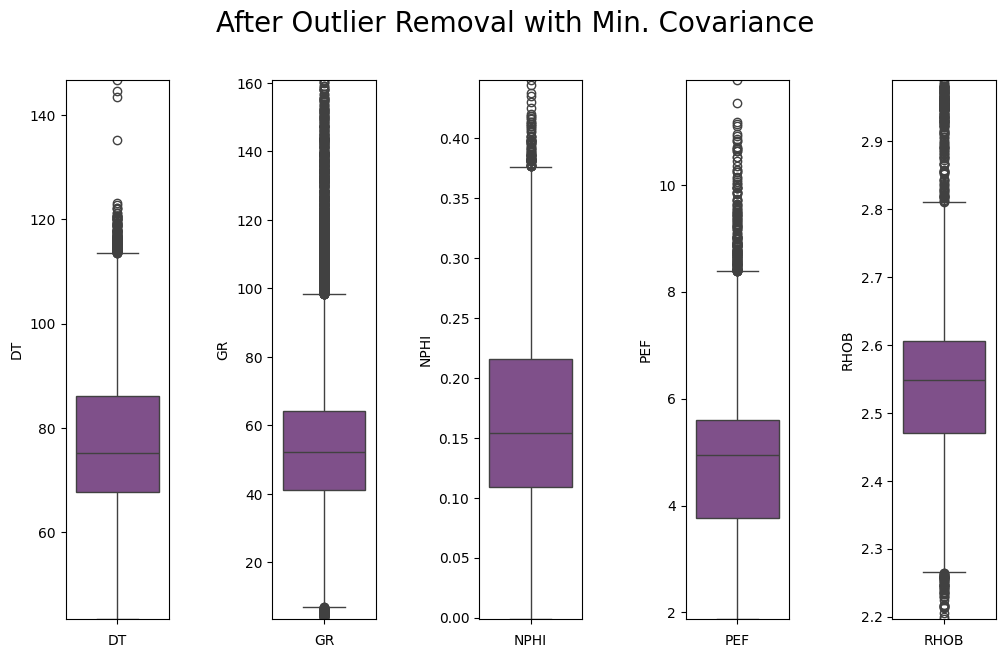

In [95]:
fig, axes = plt.subplots(1, len(columns),figsize=(12,7))
fig.suptitle('After Outlier Removal with Min. Covariance', fontsize=20)
plt.subplots_adjust(wspace = 1)
for i, col in enumerate(columns):
    ax = sns.boxplot(y=well_train_ee[col], ax=axes.flatten()[i])
    ax.set_ylim(well_train_ee[col].min(), well_train_ee[col].max())
    ax.set_xlabel(col)

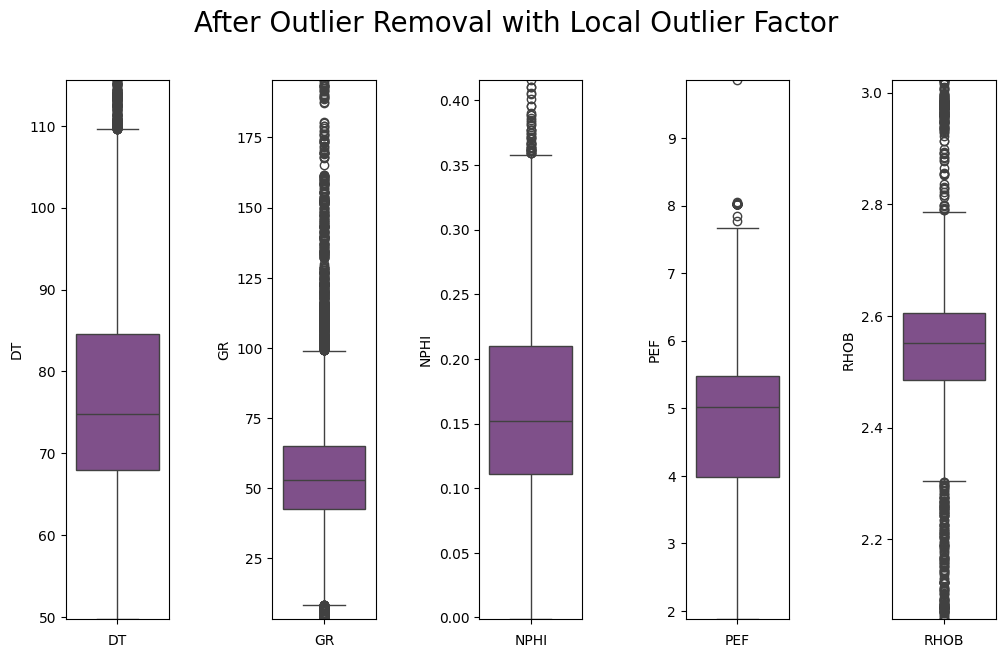

In [96]:
fig, axes = plt.subplots(1, len(columns),figsize=(12,7))
fig.suptitle('After Outlier Removal with Local Outlier Factor', fontsize=20)
plt.subplots_adjust(wspace = 1)
for i, col in enumerate(columns):
    ax = sns.boxplot(y=well_train_lof[col], ax=axes.flatten()[i])
    ax.set_ylim(well_train_lof[col].min(), well_train_lof[col].max())
    ax.set_xlabel(col)

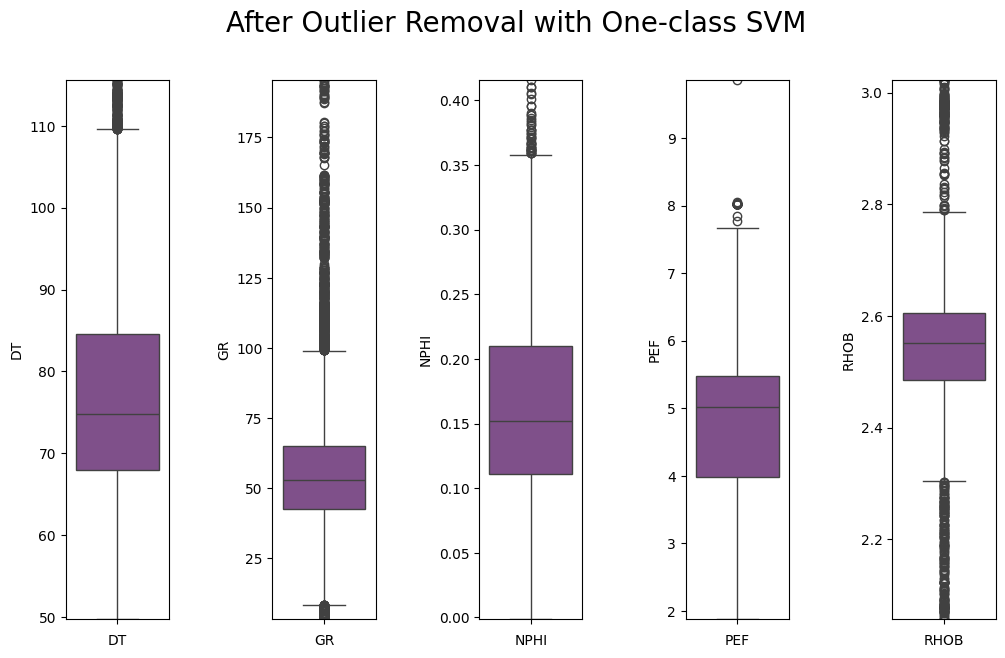

In [97]:
fig, axes = plt.subplots(1, len(columns),figsize=(12,7))
fig.suptitle('After Outlier Removal with One-class SVM', fontsize=20)
plt.subplots_adjust(wspace = 1)
for i, col in enumerate(columns):
    ax = sns.boxplot(y=well_train_lof[col], ax=axes.flatten()[i])
    ax.set_ylim(well_train_lof[col].min(), well_train_lof[col].max())
    ax.set_xlabel(col)

In [110]:
main_df

index       MD             DT            GR          NPHI  \
0      13286   6643.0  177.764000000  29.973600000  0.4900000000   
1      13287   6643.5   98.444000000  32.972400000  0.4590000000   
2      13288   6644.0   98.633000000  46.114200000  0.4610000000   
3      13289   6644.5  104.232000000  56.622600000  0.4340000000   
4      13290   6645.0  118.779000000  61.119000000  0.3450000000   
...      ...      ...            ...           ...           ...   
17445  69147  11031.5   68.750297546  39.419898987  0.2630000114   
17446  69148  11032.0   68.750297546  39.419898987  0.2630000114   
17447  69149  11032.5   68.750297546  39.419898987  0.2630000114   
17448  69150  11033.0   68.750297546  39.419898987  0.2630000114   
17449  69151  11033.5   68.750297546  39.419898987  0.2630000114   

                 PEF            RD          RHOB wellName  
0      42.5740000000  0.5419999957  2.0910000000   well_1  
1      19.5680000000  0.3499999940  2.4960000000   well_1  
2      13.8510000000  0.2329999954  2.5390000000   well_1  
3       9.2390000000  0.1469999999  2.2640000000   well_1  
4       7.2760000000  0.1099999994  2.2570000000   well_1  
...              ...           ...           ...      ...  
17445   4.1895518303  0.7548000216  2.0139031410   well_3  
17446   4.1954121590  0.7550999522  2.0148868561   well_3  
17447   4.2011322975  0.7553988099  2.0158813000   well_3  
17448   4.1402673721  0.7555977702  2.0330317020   well_3  
17449   4.0786161423  0.7555999756  2.0503728390   well_3  

[17450 rows x 9 columns]

In [133]:
main_df.describe().T

count             mean              std              min  \
MD    12829.0  9578.6731623665  1292.8574681702  6644.5000000000   
DT    12829.0    81.3986205567    13.6226673056    50.5860000000   
GR    12829.0    65.2933930187    24.5930230374    40.0130000000   
NPHI  12829.0     0.1845584594     0.0729461994     0.0180000000   
PEF   12829.0     4.8780179018     1.3227960709     2.0001778603   
RD    12829.0     5.2760462836     9.6406762976     0.1099999994   
RHOB  12829.0     2.5394858877     0.0836829112     2.1390000000   

                  25%              50%               75%              max  
MD    8708.0000000000  9834.5000000000  10601.5000000000  11765.000000000  
DT      71.2700000000    78.5840000000     90.1810000000    119.911000000  
GR      49.8280000000    56.7954368590     72.2863693240    199.801895140  
NPHI     0.1310000000     0.1710000000      0.2340000000      0.445000000  
PEF      4.0482769012     4.9950000000      5.6258783340      9.955781000  
RD       1.2310000000     2.5369999409      6.1928081512    265.841003418  
RHOB     2.4840000000     2.5480000000      2.6010000000      2.965000000

In [134]:
main_df.drop(main_df[(main_df.GR >150) | (main_df.GR<40)].index, inplace=True)

In [135]:
main_df.drop(main_df[(main_df.DT >120) | (main_df.DT<40)].index, inplace=True)

In [136]:
main_df.drop(main_df[(main_df.PEF >10) | (main_df.PEF<1)].index, inplace=True)

In [137]:
main_df.drop(main_df[(main_df.RHOB >3) | (main_df.RHOB<1.8)].index, inplace=True)

In [138]:
main_df.shape

(12617, 8)

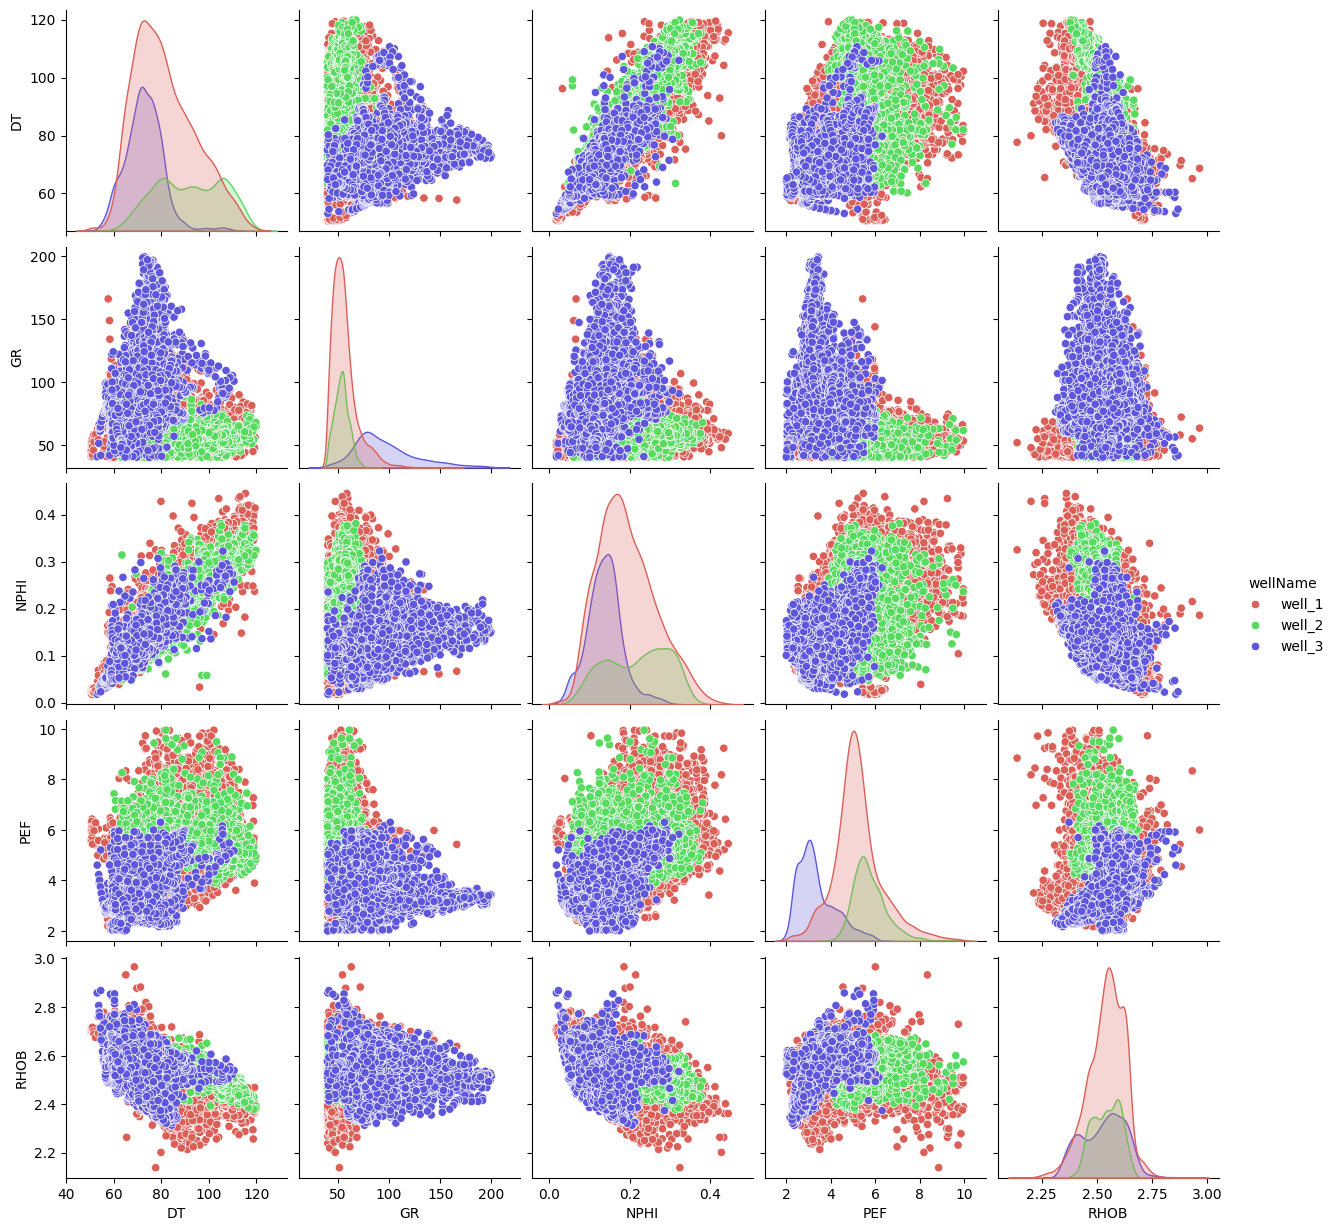

In [138]:
sns.pairplot(main_df[['DT', 'GR', 'NPHI', 'PEF','RHOB', 'wellName']],
             hue='wellName',
             palette='hls',
             diag_kind = 'kde',
             )

In [145]:
main_df.to_csv('./sonic_wells_data/df_outli_removed.csv', index=False)

## 03_Model Create

In [4]:
main_df=pd.read_csv('./sonic_wells_data/df_outli_removed.csv')

In [5]:
main_df

MD          DT          GR      NPHI       PEF        RD  \
0       6644.5  104.232000   56.622600  0.434000  9.239000  0.147000   
1       6645.0  118.779000   61.119000  0.345000  7.276000  0.110000   
2       6645.5  115.293000   64.584000  0.332000  7.898000  0.117000   
3       6646.0   87.754000   65.849400  0.331000  8.312000  0.128000   
4       6646.5   88.320000   67.285800  0.333000  9.289000  0.184000   
...        ...         ...         ...       ...       ...       ...   
12612  10898.5   59.295597  122.082718  0.206799  2.260631  2.349990   
12613  10899.0   59.844658  124.104309  0.208922  2.314458  4.086686   
12614  10899.5   60.691143  107.001129  0.190541  2.366723  5.902391   
12615  10900.0   61.848755   79.140839  0.156513  2.339912  5.756774   
12616  10900.5   63.052856   47.980896  0.116266  2.301285  3.716029   

           RHOB wellName  
0      2.264000   well_1  
1      2.257000   well_1  
2      2.288000   well_1  
3      2.325000   well_1  
4      2.280000   well_1  
...         ...      ...  
12612  2.620037   well_3  
12613  2.613721   well_3  
12614  2.605176   well_3  
12615  2.574277   well_3  
12616  2.540038   well_3  

[12617 rows x 8 columns]

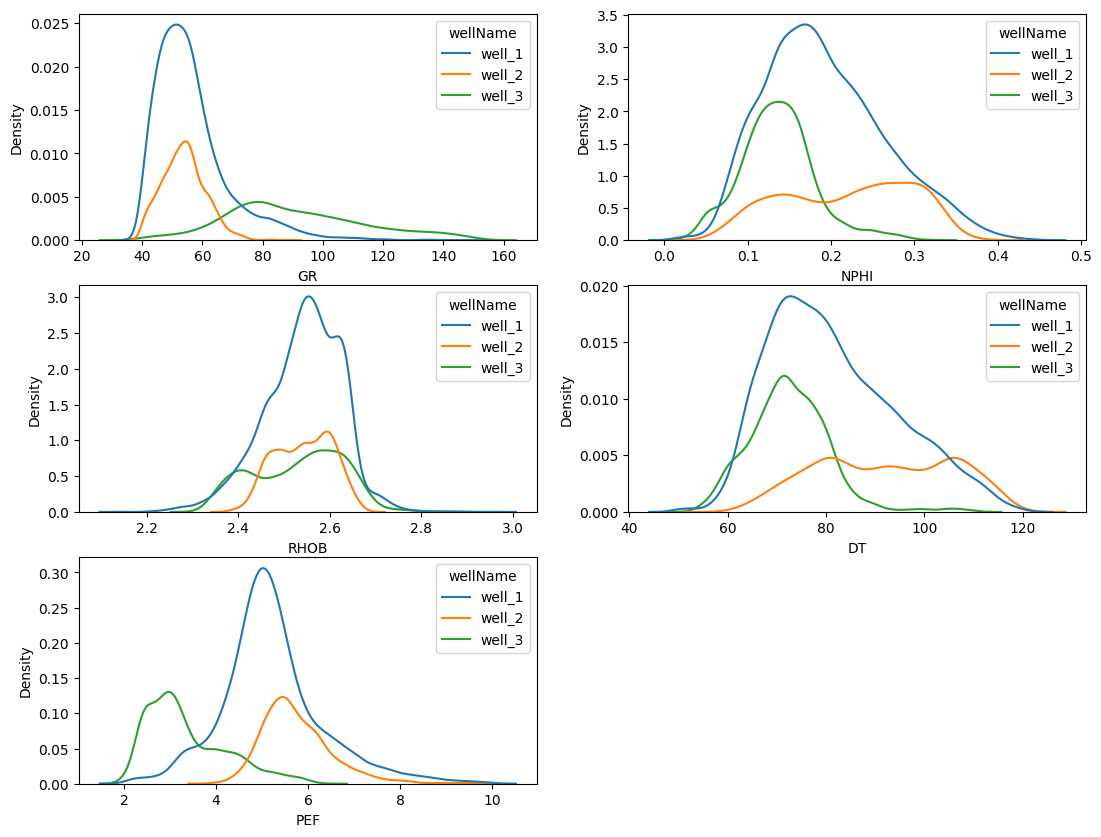

In [6]:
plt.figure(figsize=(13,10))

plt.subplot(3,2,1)
sns.kdeplot(data=main_df,hue=main_df['wellName'], x=main_df['GR'])

plt.subplot(3,2,2)
sns.kdeplot(data=main_df, hue=main_df['wellName'],x=main_df["NPHI"] )

plt.subplot(3,2,3)
sns.kdeplot(data=main_df, hue=main_df['wellName'],x=main_df["RHOB"] )

plt.subplot(3,2,4)
sns.kdeplot(data=main_df, hue=main_df['wellName'],x=main_df["DT"] )

plt.subplot(3,2,5)
sns.kdeplot(data=main_df, hue=main_df['wellName'],x=main_df["PEF"] )
plt.show()

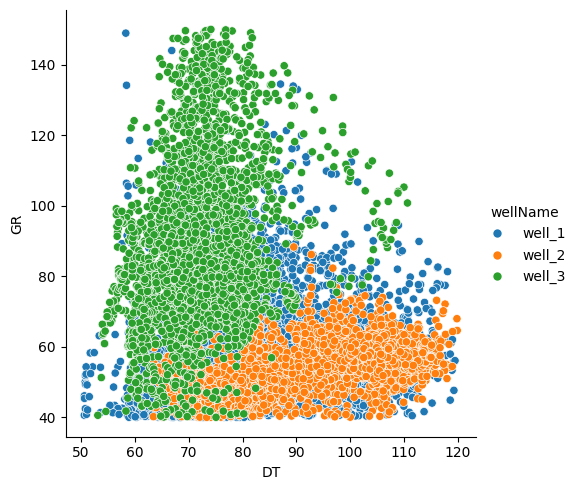

In [7]:
# Plotting a scatterplot of the relationship of age and charges
sns.relplot(data=main_df, x='DT', y='GR', hue='wellName')
plt.show()

### Standrization and Normalization

In [8]:
main_df.drop(columns=['MD'], inplace=True)

In [9]:
main_df

DT          GR      NPHI       PEF        RD      RHOB wellName
0      104.232000   56.622600  0.434000  9.239000  0.147000  2.264000   well_1
1      118.779000   61.119000  0.345000  7.276000  0.110000  2.257000   well_1
2      115.293000   64.584000  0.332000  7.898000  0.117000  2.288000   well_1
3       87.754000   65.849400  0.331000  8.312000  0.128000  2.325000   well_1
4       88.320000   67.285800  0.333000  9.289000  0.184000  2.280000   well_1
...           ...         ...       ...       ...       ...       ...      ...
12612   59.295597  122.082718  0.206799  2.260631  2.349990  2.620037   well_3
12613   59.844658  124.104309  0.208922  2.314458  4.086686  2.613721   well_3
12614   60.691143  107.001129  0.190541  2.366723  5.902391  2.605176   well_3
12615   61.848755   79.140839  0.156513  2.339912  5.756774  2.574277   well_3
12616   63.052856   47.980896  0.116266  2.301285  3.716029  2.540038   well_3

[12617 rows x 7 columns]

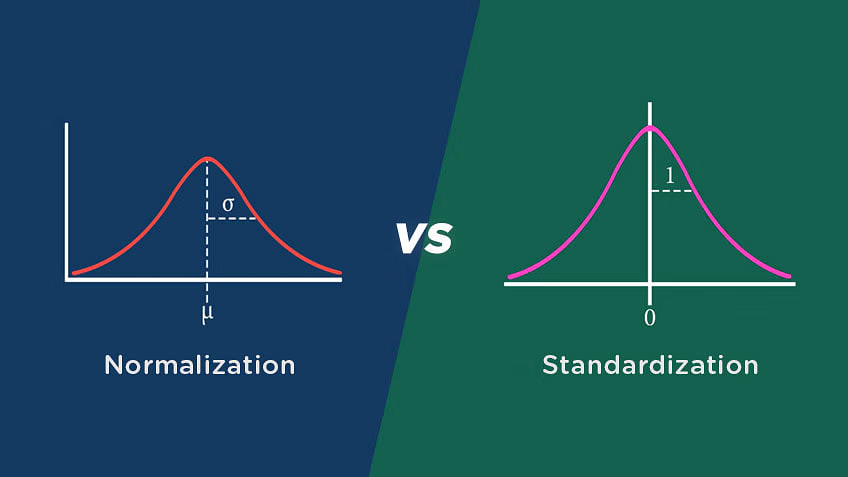

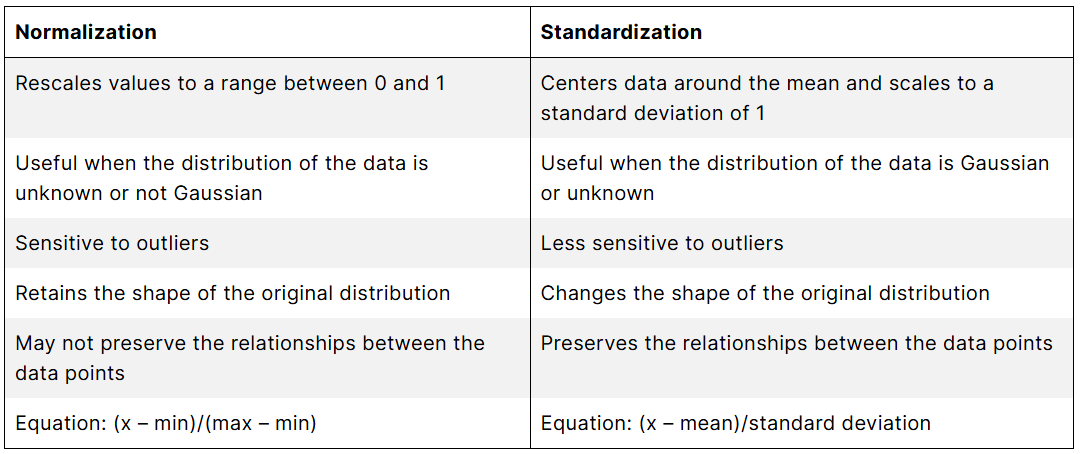

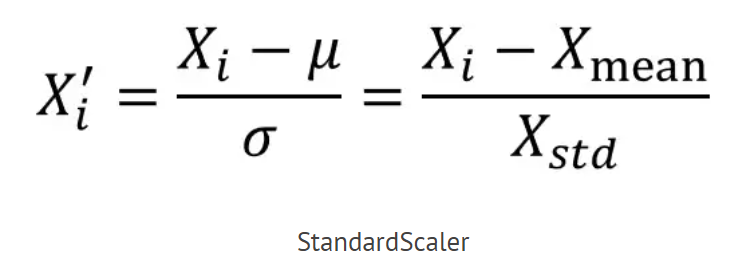

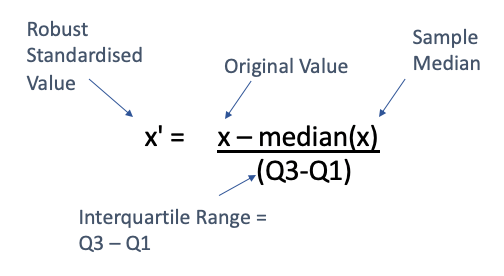

In [10]:
feature = ['GR', 'NPHI', 'PEF', 'RHOB']
target = 'DT'

In [11]:
scaler = RobustScaler()

In [12]:
model = RandomForestRegressor()
pipeline = Pipeline(steps=[('s',scaler), ('m', model)])

In [13]:
X=main_df[feature]
y=main_df[target]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=42)

In [15]:
pipeline.fit(X_train, y_train)
test_predictions = pipeline.predict(X_test)

In [16]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, test_predictions))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, test_predictions))

Mean squared error: 21.31
Coefficient of determination: 0.89


In [18]:
model_LR = LinearRegression()

In [19]:
# Train the model using the training sets
model_LR.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = model_LR.predict(X_test)

# The coefficients
print("Coefficients: \n", model_LR.coef_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))




Coefficients: 
 [-7.65592397e-03  1.40288436e+02  1.34592669e+00 -3.11159773e+01]
Mean squared error: 29.90
Coefficient of determination: 0.84


R²: Values around 0.85 indicate that approximately 85% of the variability in the dependent variable can be explained by the model.
RMSE: A value of 0.1556 suggests the model's prediction error is relatively low.

ValueError: Length of values (2524) does not match length of index (12617)

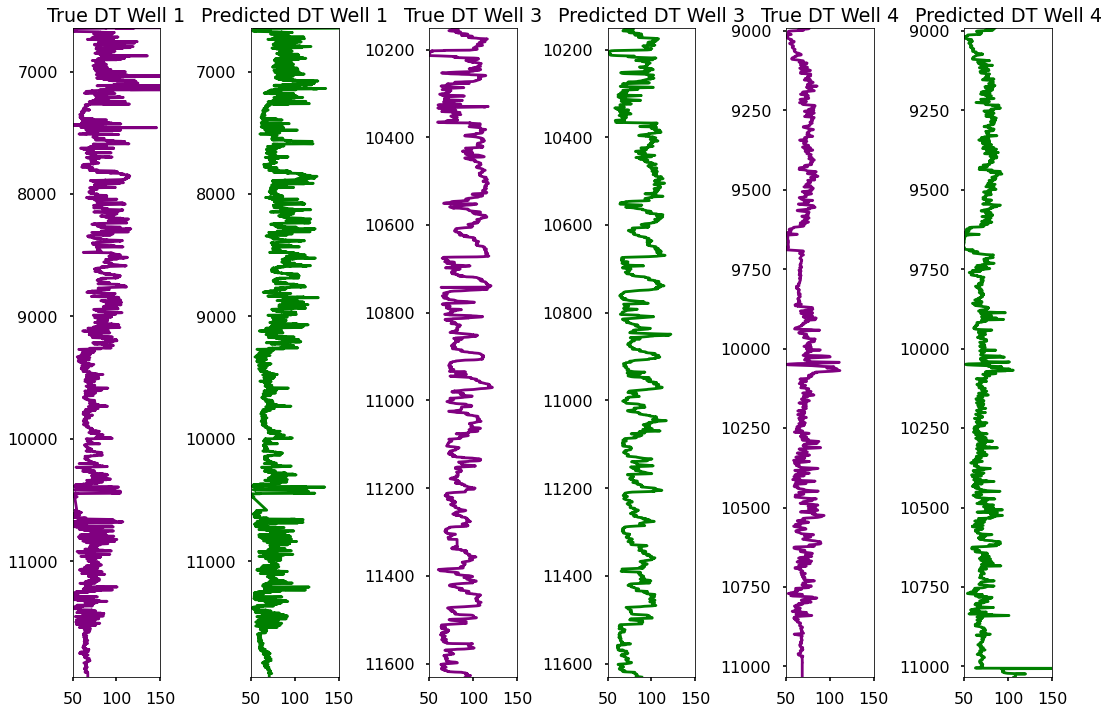

In [38]:
x = [y_test1, y_pred1, y_test3, y_pred3, y_test4, y_pred4]
y = [well_11['MD'],well_11['MD'], well_22['MD'], well_22['MD'], well_33['MD'], well_33['MD']]

color = ['purple', 'green', 'purple', 'green', 'purple', 'green']
title = ['True DT Well 1', 'Predicted DT Well 1', 'True DT Well 3', 'Predicted DT Well 3',
         'True DT Well 4', 'Predicted DT Well 4']

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15,10))

for i in range(len(x)):
  ax[i].plot(x[i], y[i], color=color[i])
  ax[i].set_xlim(50, 150)
  ax[i].set_ylim(np.max(y[i]), np.min(y[i]))
  ax[i].set_title(title[i])

plt.tight_layout(1)

plt.show()

In [41]:
model = GradientBoostingRegressor()

## Hyperparameters
max_depth = [10, 100]
# max_features = ['auto', 'sqrt']
min_samples_leaf = [1, 4]
min_samples_split = [2, 10]
n_estimators = [100, 1000]

param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth}

## Randomized CV
model_random = GridSearchCV(model, param_grid, cv=3)
model_random.fit(X_train, y_train)

## print best model
model_random.best_params_

{'max_depth': 10, 'n_estimators': 100}

In [51]:
#X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, ground_truth_data, 
#    test_size=0.3,random_state =1 )

# Define the X and y from the SVM normalized dataset
Xm = well_train_svm[only_feature].values
ym = well_train_svm[only_target].values

# Train and test split
X_trainm, X_testm, y_trainm, y_testm = train_test_split(Xm, ym, test_size=0.3, random_state=42)
modelm = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(modelm,parameters, cv=None)
grid.fit(X_trainm, y_trainm)
print("r2 / variance : ", grid.best_score_ )
print("Residual sum of squares: %.2f" % np.mean((grid.predict(X_testm) - y_testm) ** 2))

r2 / variance :  0.9005799003092706
Residual sum of squares: 0.09


In [52]:
grid.best_params_

{'copy_X': True, 'fit_intercept': True, 'normalize': True}

In [54]:
y_predm = grid.predict(X_testm)
print("R-squared of Well 4: {}".format(grid.score(X_testm, y_testm)))
rmse = np.sqrt(mean_squared_error(y_testm, y_predm))
print("RMSE of Well 4: {}".format(rmse))

R-squared of Well 4: 0.895981096114532
RMSE of Well 4: 0.3021240621304735


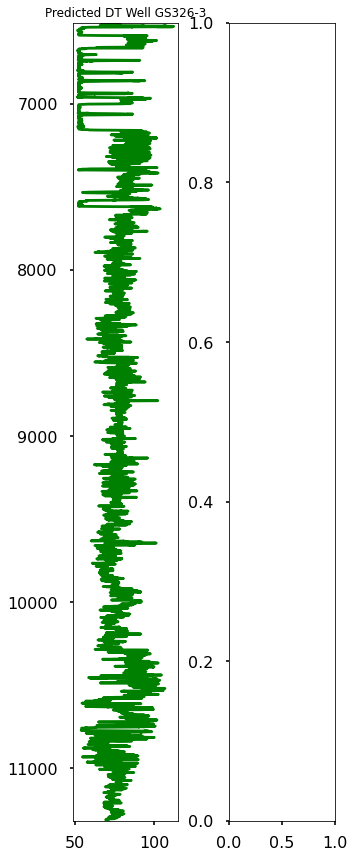

In [60]:
plt.figure(figsize=(5,12))

plt.subplot(1,2,1)
plt.plot(y_pred3, depth_GS326_3, color='green')
plt.ylim(max(depth_GS326_3), min(depth_GS326_3))
plt.title('Predicted DT Well GS326-3', size=12)

plt.subplot(1,2,2)
# plt.plot(y_pred5, depth5, color='green')
# plt.ylim(max(depth5), min(depth5))
# plt.title('Predicted DT Well 5', size=12)

plt.tight_layout(1)
plt.show()

In [61]:
well_GS365_1 = lasio.read('sonic_wells_data/GS365-1.las').df().reset_index()

In [62]:
well_GS365_1.describe()

MD            DT            GR          NPHI            RD  \
count  45132.000000  34885.000000  34901.000000  14973.000000  14881.000000   
mean    5641.375000     71.271169     37.388915      0.162436    254.557986   
std     3257.157628      9.640161     24.990580      0.100310    614.834336   
min        0.000000     49.404440      3.190000     -0.024900      0.263300   
25%     2820.687500     67.197850     10.468800      0.104500      1.505000   
50%     5641.375000     67.917950     40.687500      0.169400      2.817000   
75%     8462.062500     75.309400     49.000000      0.230000     17.183600   
max    11282.750000    140.792100    160.125000      0.520500   2000.000000   

               RHOB  
count  14973.000000  
mean       2.443452  
std        0.237623  
min        1.633000  
25%        2.373000  
50%        2.485500  
75%        2.567300  
max        3.121100

KeyError: 'PEF'

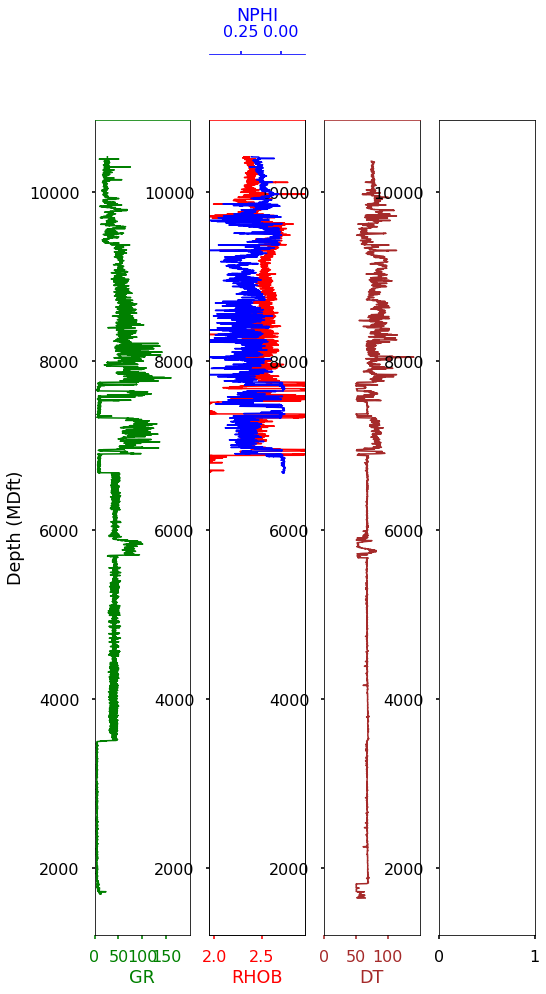

In [63]:
create_well_log_plot(well_GS365_1)

## 04_Model Test

### Well_1

In [15]:
#Blind_well
blind_well = lasio.read('sonic_wells_data/GS365-A5.las').df().reset_index()


In [16]:
blind_well.describe()

MD               DT               GR             NPHI  \
count  24068.000000000  9302.0000000000  9302.0000000000  3331.0000000000   
mean    6016.750000000    75.7915077553    88.0092387121     0.1322092465   
std     3473.988737748    13.8023185856    47.1375732371     1.5834034206   
min        0.000000000    47.7853800000    20.9515100000   -90.8787000000   
25%     3008.375000000    66.8552625000    64.0928525000     0.0940000000   
50%     6016.750000000    75.4426700000    87.6527600000     0.1486000000   
75%     9025.125000000    84.0796725000   106.4187500000     0.2158500000   
max    12033.500000000   142.3478000000   689.4138000000     3.2288000000   

                   PEF               RD             RHOB  
count  3337.0000000000  3347.0000000000  3337.0000000000  
mean      5.2387059934    18.9896312035     2.5772234342  
std       0.9470993720    62.5159519471     0.1121035527  
min       3.0526000000     0.8250000000     2.1118000000  
25%       4.6476000000     2.4169500000     2.5233000000  
50%       5.0288000000     3.7465000000     2.5770000000  
75%       5.6515000000     6.1302005000     2.6227000000  
max       8.9552000000   690.7872000000     3.0292000000

In [17]:
blind_well.rename({'DEPT':'MD'}, axis=1, inplace=True)

In [18]:
blind_well.dropna(axis=0, inplace=True)

In [19]:
blind_well

MD        DT        GR    NPHI     PEF       RD    RHOB
19261   9630.5  64.45525  66.69039  3.2288  5.3774   3.7465  2.6219
19262   9631.0  64.96075  65.85606  0.7985  5.3774   3.7465  2.6219
19263   9631.5  65.70430  67.41348  3.2288  5.3774   3.7465  2.6219
19264   9632.0  67.70583  70.78786 -0.0056  5.3774   3.7465  2.6219
19265   9632.5  69.07289  75.37666 -0.0511  5.3434   3.7465  2.6156
...        ...       ...       ...     ...     ...      ...     ...
22586  11293.0  55.36653  61.56607  0.0326  6.0977  27.4411  2.6330
22587  11293.5  54.66113  63.26949  0.0356  6.1794  28.0580  2.6447
22588  11294.0  54.85334  68.72043  0.0348  6.2044  29.0441  2.6656
22589  11294.5  54.19085  70.15617  0.0298  6.0904  29.1046  2.6614
22590  11295.0  53.49689  72.55718  0.0218  5.9433  39.3215  2.6577

[3321 rows x 7 columns]

In [20]:
create_well_log_plot(blind_well)


NameError: name 'create_well_log_plot' is not defined

In [21]:
blind_well_feature=blind_well[feature]

In [22]:
blind_well_feature

GR    NPHI     PEF    RHOB
19261  66.69039  3.2288  5.3774  2.6219
19262  65.85606  0.7985  5.3774  2.6219
19263  67.41348  3.2288  5.3774  2.6219
19264  70.78786 -0.0056  5.3774  2.6219
19265  75.37666 -0.0511  5.3434  2.6156
...         ...     ...     ...     ...
22586  61.56607  0.0326  6.0977  2.6330
22587  63.26949  0.0356  6.1794  2.6447
22588  68.72043  0.0348  6.2044  2.6656
22589  70.15617  0.0298  6.0904  2.6614
22590  72.55718  0.0218  5.9433  2.6577

[3321 rows x 4 columns]

In [23]:
depth_blind_well = blind_well['MD'].values

In [24]:
y_pred_blind_well = pipeline.predict(blind_well_feature)

In [25]:
y_pred_blind_well

array([91.60910647, 91.62504647, 91.33410535, ..., 61.6778982 ,
       54.2090431 , 53.62687986])

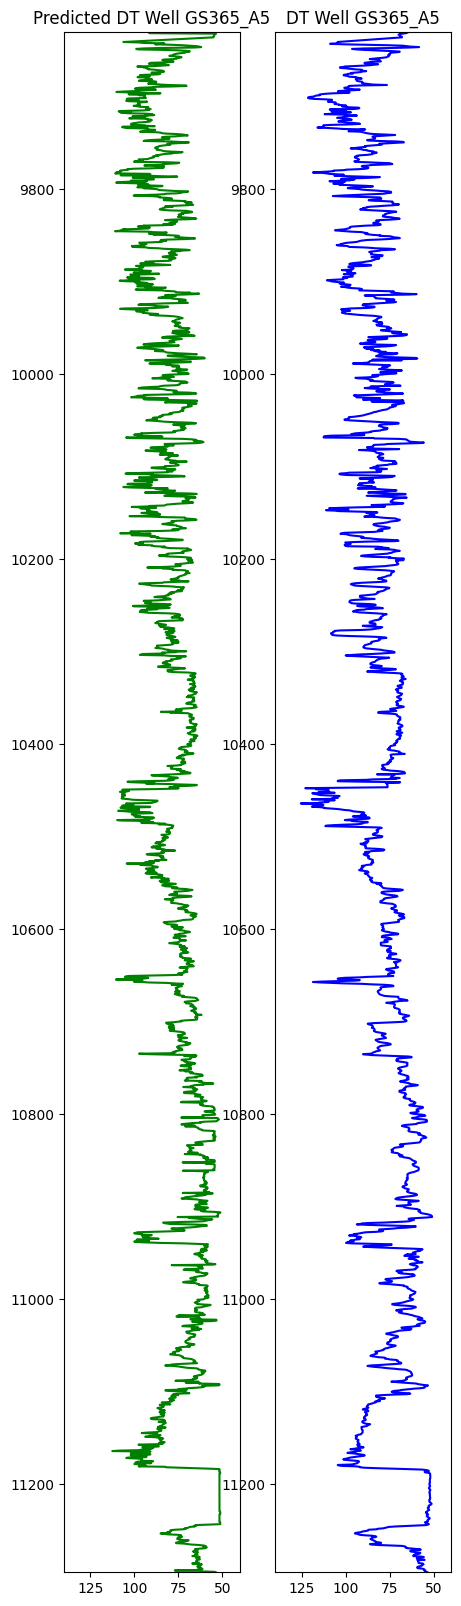

In [26]:
plt.figure(figsize=(5,20))

plt.subplot(1,2,1)
plt.plot(y_pred_blind_well, depth_blind_well, color='green')
plt.ylim(max(depth_blind_well), min(depth_blind_well))

plt.xlim(140, 40)
plt.title('Predicted DT Well GS365_A5', size=12)

plt.subplot(1,2,2)
plt.plot(blind_well['DT'], depth_blind_well, color='blue')
plt.ylim(max(depth_blind_well), min(depth_blind_well))
plt.xlim(140, 40)
plt.title('DT Well GS365_A5', size=12)

plt.show()

### Well_2

In [27]:
#Blind_well
blind_well = lasio.read('sonic_wells_data/GS324-5(EDFU-A4).las').df().reset_index()


In [30]:
blind_well.describe().T

count             mean              std              min  \
MD         40811.0  7101.2500000000  2945.3163136580  2000.0000000000   
RD         17776.0    12.7471665048    70.4203387310     0.3308791220   
CALI        6554.0     6.0918279107     0.3714918054     5.7318382263   
BS          6555.0     6.0000000000     0.0000000000     6.0000000000   
PEF         6535.0     3.8561453863     1.0744877054     1.7235000134   
DRHO        6535.0     0.0160551800     0.0769827764    -0.0155000000   
RHOB        6535.0     2.5958541831     0.1104962141     2.1022000313   
NPHI        6555.0     0.1324897635     0.0654977284     0.0206000004   
DT         20627.0    77.1496599134    13.3051975365    34.7333984380   
GR         20418.0    66.8800828803    26.6075848298     8.6647996902   
PHIT        6509.0     0.1026445344     0.0433421456     0.0115636801   
PHI_FINAL   6509.0     0.0250417419     0.0377827697     0.0000000000   

                       25%              50%              75%               max  
MD         4550.6250000000  7101.2500000000  9651.8750000000  12202.5000000000  
RD            1.2529833913     2.5999999046     5.4000000954   4326.9340820000  
CALI          6.0000908374     6.0395002365     6.0888622999      8.9215507507  
BS            6.0000000000     6.0000000000     6.0000000000      6.0000000000  
PEF           3.4342749119     4.0305500031     4.6560997963      9.5332002640  
DRHO         -0.0010500000     0.0018500001     0.0080750003      2.3776001930  
RHOB          2.5533001423     2.6073000431     2.6361249685      3.9753000736  
NPHI          0.0874999985     0.1159500033     0.1666000038      0.5004000068  
DT           67.0025978090    74.4311065670    86.0830001830    130.3560028100  
GR           55.0367507930    66.5007972720    77.0878105165    526.9559936500  
PHIT          0.0739202499     0.0984799564     0.1223303974      0.4493134022  
PHI_FINAL     0.0000000000     0.0000000000     0.0359441265      0.1463820040

In [29]:
blind_well.rename({'DEPT':'MD'}, axis=1, inplace=True)

In [31]:
blind_well.dropna(axis=0, inplace=True)

In [32]:
blind_well

MD            RD          CALI   BS           PEF          DRHO  \
33608  10402.00  4.2841134071  6.5186738968  6.0  7.1799998283  0.1264999956   
33609  10402.25  4.2760000229  6.7341098785  6.0  6.4022998810  0.0736499950   
33610  10402.50  4.2760000229  6.9635095596  6.0  5.6245999336  0.0208000001   
33611  10402.75  4.2760000229  7.3545823097  6.0  5.2333002090  0.0299500003   
33612  10403.00  4.2760000229  7.7603316307  6.0  4.8420000076  0.0390999988   
...         ...           ...           ...  ...           ...           ...   
39458  11864.50  4.4698882103  5.9656858444  6.0  1.8093999624 -0.0037000000   
39459  11864.75  4.5441660881  5.9865326881  6.0  1.8032499552 -0.0022000000   
39460  11865.00  4.6161661148  6.0077834129  6.0  1.7970999479 -0.0007000000   
39461  11865.25  4.7411127090  6.0136013031  6.0  1.7917499542  0.0002000000   
39462  11865.50  4.8716120720  6.0178012848  6.0  1.7863999605  0.0011000000   

               RHOB          NPHI            DT            GR          PHIT  \
33608  2.8561999798  0.2435999960  79.440002441  58.483398438  0.0875577629   
33609  2.7216999531  0.2333000004  74.369102478  61.413150787  0.1176308841   
33610  2.5871999264  0.2230000049  69.298202515  64.342903137  0.1477040052   
33611  2.5812997818  0.2124000043  68.253051758  67.009948730  0.1441607028   
33612  2.5753998756  0.2018000036  67.207901001  69.677001953  0.1406174004   
...             ...           ...           ...           ...           ...   
39458  2.5033998489  0.0734999999  65.472900391  52.126998901  0.0999015495   
39459  2.5081999302  0.0753500015  65.509796143  50.502899170  0.0991280973   
39460  2.5130000114  0.0772000030  65.546699524  48.878799438  0.0983546376   
39461  2.5160999298  0.0782999992  65.787246704  47.589099884  0.0978180468   
39462  2.5191998482  0.0794000030  66.027801514  46.299400330  0.0972814485   

          PHI_FINAL  
33608  0.0000000000  
33609  0.0000000000  
33610  0.0000000000  
33611  0.0000000000  
33612  0.0000000000  
...             ...  
39458  0.1001989990  
39459  0.0994610041  
39460  0.0987230018  
39461  0.0981924534  
39462  0.0976618975  

[5855 rows x 12 columns]

In [ ]:
create_well_log_plot(blind_well)


NameError: name 'create_well_log_plot' is not defined

In [33]:
blind_well_feature=blind_well[feature]

In [34]:
blind_well_feature

GR          NPHI           PEF          RHOB
33608  58.483398438  0.2435999960  7.1799998283  2.8561999798
33609  61.413150787  0.2333000004  6.4022998810  2.7216999531
33610  64.342903137  0.2230000049  5.6245999336  2.5871999264
33611  67.009948730  0.2124000043  5.2333002090  2.5812997818
33612  69.677001953  0.2018000036  4.8420000076  2.5753998756
...             ...           ...           ...           ...
39458  52.126998901  0.0734999999  1.8093999624  2.5033998489
39459  50.502899170  0.0753500015  1.8032499552  2.5081999302
39460  48.878799438  0.0772000030  1.7970999479  2.5130000114
39461  47.589099884  0.0782999992  1.7917499542  2.5160999298
39462  46.299400330  0.0794000030  1.7863999605  2.5191998482

[5855 rows x 4 columns]

In [35]:
depth_blind_well = blind_well['MD'].values

In [36]:
y_pred_blind_well = pipeline.predict(blind_well_feature)

In [37]:
y_pred_blind_well

array([73.56032457, 73.59893922, 82.17357818, ..., 64.47661782,
       64.52141329, 64.72107319])

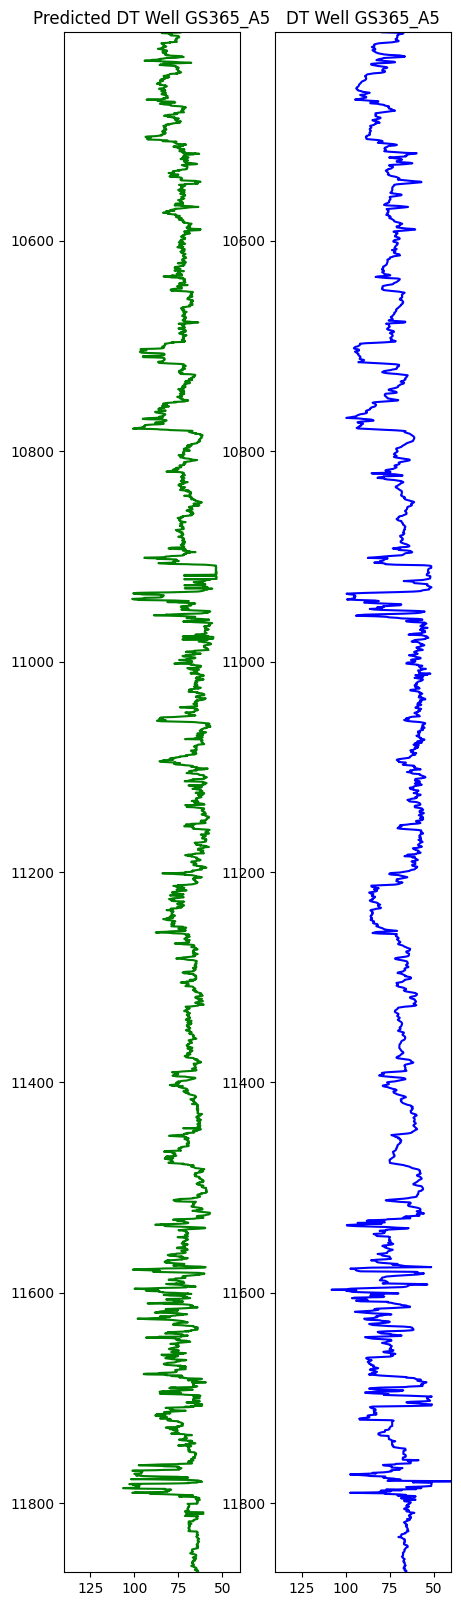

In [42]:
plt.figure(figsize=(5,20))

plt.subplot(1,2,1)
plt.plot(y_pred_blind_well, depth_blind_well, color='green')#,alpha=0.6

plt.ylim(max(depth_blind_well), min(depth_blind_well))

plt.xlim(140, 40)
plt.title('Predicted DT Well GS365_A5', size=12)

plt.subplot(1,2,2)
plt.plot(blind_well['DT'], depth_blind_well, color='blue')
plt.ylim(max(depth_blind_well), min(depth_blind_well))
plt.xlim(140, 40)
plt.title('DT Well GS365_A5', size=12)

plt.show()

In [21]:
from matplotlib  import gridspec

Flagging Methods
1st Method : The difference between the predicted and actual is larger than the mean difference then add one standard of devation

2nd Method : if it's negative

3rd Method : if it's larger than mean + one standard of devation

In [22]:
def error_flag(pred, actual, dev = 1.0, method = 1):

    flag = np.zeros(len(pred))
    err = np.abs(pred-actual)
    err_mean = np.mean(err)
    err_std = np.std(err)
    ss = np.sign(pred.diff().fillna(pred))
    ls = np.sign(actual.diff().fillna(actual))

    if method == 1:
        flag[np.where(err>(err_mean + (dev*err_std)))] = 1
    elif method == 2:      
        flag[np.where((ss + ls)==0 )]= 1
    elif method == 3:
        flag[np.where(np.logical_or(err>(err_mean + (dev*err_std)), (ss+ls)==0 ))]= 1
    return flag

In [23]:
flag = error_flag(blind_well['predicted'], blind_well['DT'], 1,  1)

NameError: name 'blind_well' is not defined

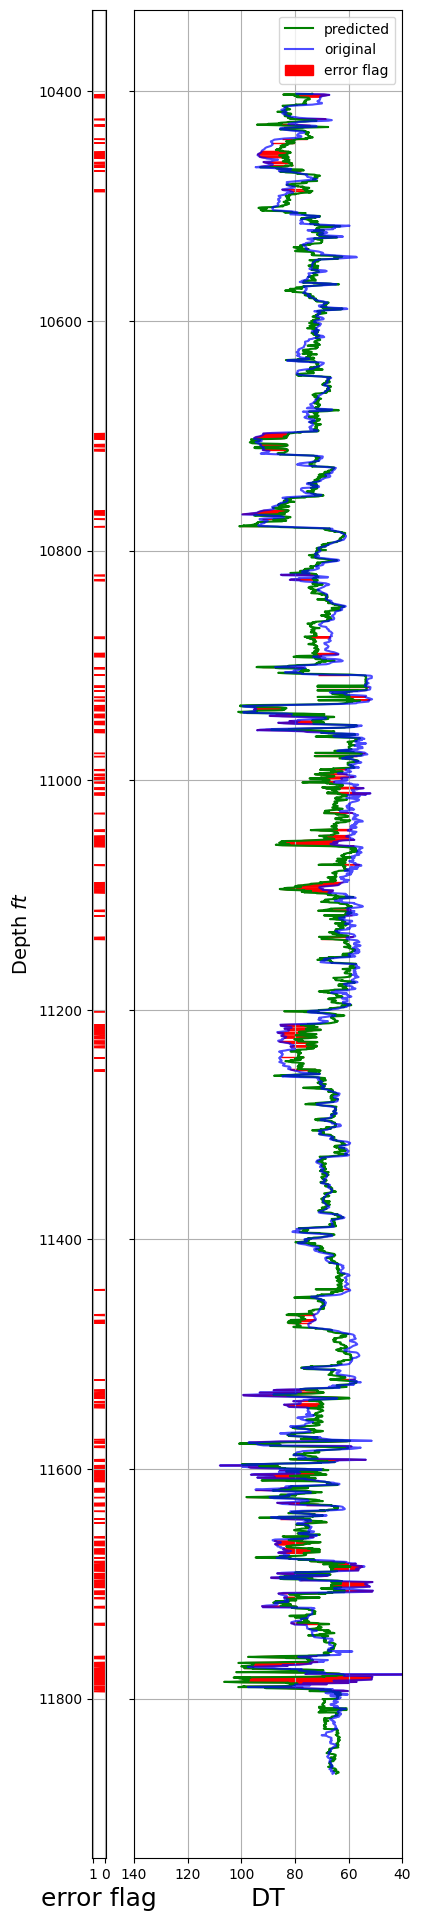

In [65]:
fig = plt.figure(figsize=(4,24))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.2, 4]) 


ax = plt.subplot(gs[0])
ax.set_ylabel(r'Depth $ft$', size=14)
ax.fill_betweenx(depth_blind_well, flag, 0, color = 'r')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel('error flag', size=18)

ax.grid()

ax1 = plt.subplot(gs[1])
ax1.plot(y_pred_blind_well, depth_blind_well, 'Green', label='predicted', )
ax1.plot(blind_well['DT'], depth_blind_well, 'blue', label='original', alpha=0.7)

ax1.fill_betweenx(depth_blind_well, y_pred_blind_well,blind_well['DT'], where=flag==1, color = 'r', label='error flag')

# Do some plot annotations
#ax1.set_title('title here')
ax1.invert_yaxis()
ax1.set_yticklabels([])
ax1.set_xlabel('DT', size=18)
ax1.legend()
ax1.grid()

plt.xlim(140, 40)
plt.show()

### Well_3

In [58]:
well_GS365_A6 = lasio.read('sonic_wells_data/GS365-A6.las').df().reset_index()


In [59]:
well_GS365_A6.describe()

MD                DT               GR             NPHI  \
count  18643.0000000000  18565.0000000000  1730.0000000000  1374.0000000000   
mean    6311.5000000000     71.9268041939    36.7280748844     0.1135238719   
std     2690.9574349414      9.7466390207    20.8110478724     0.1159242333   
min     1651.0000000000     47.9049300000    14.0502400000    -0.0448000000   
25%     3981.2500000000     67.7705200000    21.4980250000     0.0953500000   
50%     6311.5000000000     68.3445200000    27.8069400000     0.1108000000   
75%     8641.7500000000     74.9591900000    45.6811700000     0.1225750000   
max    10972.0000000000    110.1894000000   136.0813000000     3.2288000000   

                   PEF               RD             RHOB  
count  1427.0000000000  1436.0000000000  1427.0000000000  
mean      2.6730599159   124.3528761985     2.4098253679  
std       1.7726478190   266.7602036225     0.0872583618  
min       1.8723000000     0.6272000000     2.1269000000  
25%       1.9763000000     1.7815500000     2.3797500000  
50%       2.0767000000     9.3505500000     2.4158000000  
75%       2.4038500000    71.7634750000     2.4499500000  
max      10.0000000000  1623.3800000000     3.5820000000

In [60]:
well_GS365_A6=well_GS365_A6[['MD','DT','GR','NPHI','PEF','RHOB']]

In [61]:
well_GS365_A6.dropna(axis=0, inplace=True)

In [64]:
depth_well_GS365_A6 = well_GS365_A6['MD'].values

In [62]:
well_GS365_A6


MD        DT         GR    NPHI     PEF    RHOB
17207  10254.5  72.63288   67.58311  0.1763  9.8205  3.5820
17208  10255.0  71.39230   83.85313  0.1975  9.3715  2.9059
17209  10255.5  70.49920   99.32672  0.1758  8.9008  2.5705
17210  10256.0  65.88014  104.78800  0.1746  8.6286  2.4739
17211  10256.5  85.63945  111.20500  0.1492  8.6101  2.4663
...        ...       ...        ...     ...     ...     ...
18561  10931.5  72.47672   76.45772  0.1153  2.5879  2.5137
18562  10932.0  71.96988   76.45772  0.1137  2.5753  2.5182
18563  10932.5  71.61746   76.45772  0.1207  2.5217  2.5094
18564  10933.0  71.42653   76.45772  0.1277  2.4864  2.5006
18565  10933.5  71.76769   76.45772  0.1326  2.5362  2.4998

[1359 rows x 6 columns]

In [63]:
well_GS365_A6_feature=well_GS365_A6[feature]

In [65]:
y_pred_X_test_GS365_A6= pipeline.predict(well_GS365_A6_feature)

In [66]:
y_pred_X_test_GS365_A6

array([65.81227193, 71.95404273, 82.23072105, ..., 72.04807939,
       71.54937126, 73.12487601])

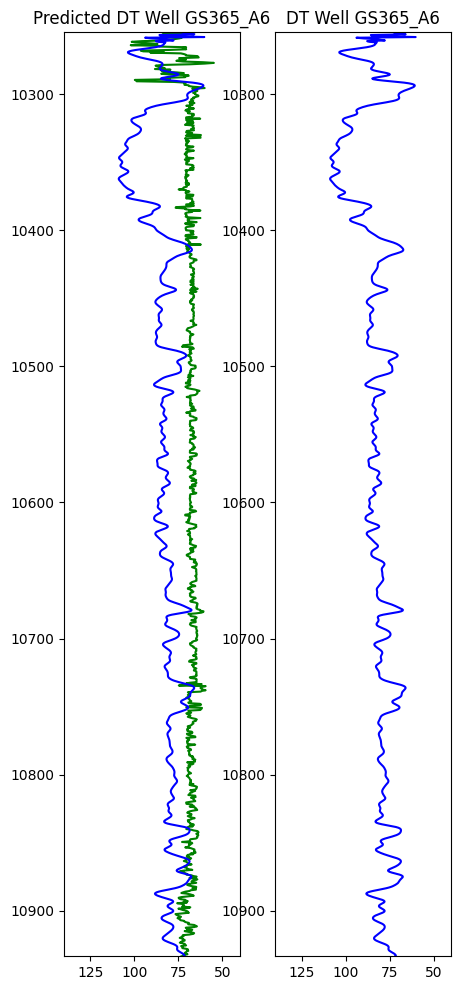

In [68]:
plt.figure(figsize=(5,12))

plt.subplot(1,2,1)
plt.plot(y_pred_X_test_GS365_A6, depth_well_GS365_A6, color='green')
plt.plot(well_GS365_A6['DT'], depth_well_GS365_A6, color='blue')
plt.ylim(max(depth_well_GS365_A6), min(depth_well_GS365_A6))
plt.xlim(140, 40)
plt.title('Predicted DT Well GS365_A6', size=12)

plt.subplot(1,2,2)
plt.plot(well_GS365_A6['DT'], depth_well_GS365_A6, color='blue')
plt.ylim(max(depth_well_GS365_A6), min(depth_well_GS365_A6))
plt.xlim(140, 40)
plt.title('DT Well GS365_A6', size=12)

#plt.tight_layout(1)
plt.show()

In [47]:
blind_well['predicted']=y_pred_blind_well

In [48]:
blind_well

MD            RD          CALI   BS           PEF          DRHO  \
33608  10402.00  4.2841134071  6.5186738968  6.0  7.1799998283  0.1264999956   
33609  10402.25  4.2760000229  6.7341098785  6.0  6.4022998810  0.0736499950   
33610  10402.50  4.2760000229  6.9635095596  6.0  5.6245999336  0.0208000001   
33611  10402.75  4.2760000229  7.3545823097  6.0  5.2333002090  0.0299500003   
33612  10403.00  4.2760000229  7.7603316307  6.0  4.8420000076  0.0390999988   
...         ...           ...           ...  ...           ...           ...   
39458  11864.50  4.4698882103  5.9656858444  6.0  1.8093999624 -0.0037000000   
39459  11864.75  4.5441660881  5.9865326881  6.0  1.8032499552 -0.0022000000   
39460  11865.00  4.6161661148  6.0077834129  6.0  1.7970999479 -0.0007000000   
39461  11865.25  4.7411127090  6.0136013031  6.0  1.7917499542  0.0002000000   
39462  11865.50  4.8716120720  6.0178012848  6.0  1.7863999605  0.0011000000   

               RHOB          NPHI            DT            GR          PHIT  \
33608  2.8561999798  0.2435999960  79.440002441  58.483398438  0.0875577629   
33609  2.7216999531  0.2333000004  74.369102478  61.413150787  0.1176308841   
33610  2.5871999264  0.2230000049  69.298202515  64.342903137  0.1477040052   
33611  2.5812997818  0.2124000043  68.253051758  67.009948730  0.1441607028   
33612  2.5753998756  0.2018000036  67.207901001  69.677001953  0.1406174004   
...             ...           ...           ...           ...           ...   
39458  2.5033998489  0.0734999999  65.472900391  52.126998901  0.0999015495   
39459  2.5081999302  0.0753500015  65.509796143  50.502899170  0.0991280973   
39460  2.5130000114  0.0772000030  65.546699524  48.878799438  0.0983546376   
39461  2.5160999298  0.0782999992  65.787246704  47.589099884  0.0978180468   
39462  2.5191998482  0.0794000030  66.027801514  46.299400330  0.0972814485   

          PHI_FINAL      predicted  
33608  0.0000000000  73.5603245737  
33609  0.0000000000  73.5989392176  
33610  0.0000000000  82.1735781780  
33611  0.0000000000  84.3974998046  
33612  0.0000000000  81.8853776239  
...             ...            ...  
39458  0.1001989990  63.7615254853  
39459  0.0994610041  64.1073242889  
39460  0.0987230018  64.4766178183  
39461  0.0981924534  64.5214132928  
39462  0.0976618975  64.7210731884  

[5855 rows x 13 columns]

In [43]:
from matplotlib  import gridspec

Flagging Methods
1st Method : The difference between the predicted and actual is larger than the mean difference then add one standard of devation

2nd Method : if it's negative

3rd Method : if it's larger than mean + one standard of devation

In [44]:
def error_flag(pred, actual, dev = 1.0, method = 1):

    flag = np.zeros(len(pred))
    err = np.abs(pred-actual)
    err_mean = np.mean(err)
    err_std = np.std(err)
    ss = np.sign(pred.diff().fillna(pred))
    ls = np.sign(actual.diff().fillna(actual))

    if method == 1:
        flag[np.where(err>(err_mean + (dev*err_std)))] = 1
    elif method == 2:      
        flag[np.where((ss + ls)==0 )]= 1
    elif method == 3:
        flag[np.where(np.logical_or(err>(err_mean + (dev*err_std)), (ss+ls)==0 ))]= 1
    return flag

In [50]:
flag = error_flag(blind_well['predicted'], blind_well['DT'], 1,  1)

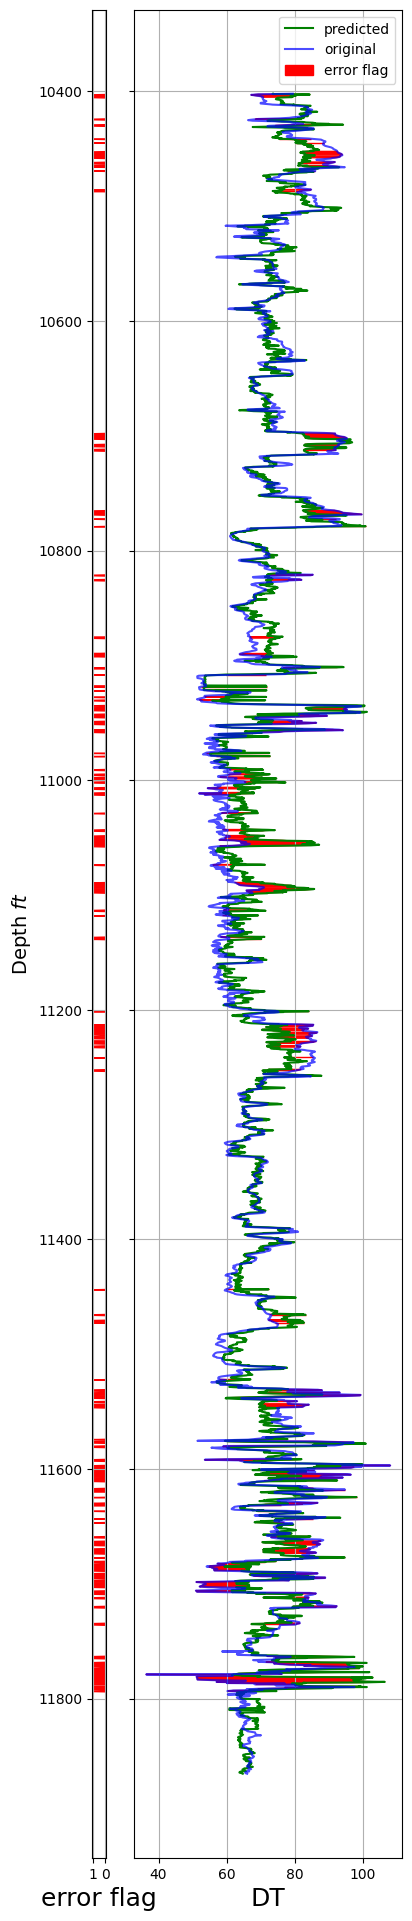

In [63]:
fig = plt.figure(figsize=(4,24))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.2, 4]) 


ax = plt.subplot(gs[0])
ax.set_ylabel(r'Depth $ft$', size=14)
ax.fill_betweenx(depth_blind_well, flag, 0, color = 'r')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel('error flag', size=18)

ax.grid()

ax1 = plt.subplot(gs[1])
ax1.plot(y_pred_blind_well, depth_blind_well, 'Green', label='predicted', )
ax1.plot(blind_well['DT'], depth_blind_well, 'blue', label='original', alpha=0.7)
ax1.fill_betweenx(depth_blind_well, y_pred_blind_well,blind_well['DT'], where=flag==1, color = 'r', label='error flag')

# Do some plot annotations
#ax1.set_title('title here')
ax1.invert_yaxis()
ax1.set_yticklabels([])
ax1.set_xlabel('DT', size=18)

ax1.legend()
    
ax1.grid()
plt.show()

### Well_2

In [79]:
#Blind_well
blind_well = lasio.read('sonic_wells_data/GS324-8(EDFU-A7).las').df().reset_index()


In [80]:
blind_well.describe().T

count              mean               std              min  \
DEPT       47738.0   7182.6250000000   3445.2294780246  1215.5000000000   
PEF        23491.0      5.9797778449      2.6807588732     2.2999999523   
RD         39753.0  26929.0090432428  43433.3956495428     0.0460000001   
RS         27976.0  40334.8839720158  47748.4166238726     0.1920000017   
DRHO       23491.0      0.0363115237      0.2383761392    -8.2799997330   
RHOB       23491.0      2.4999570258      0.1820556297    -5.1999998090   
NPHI       23417.0      0.1994318039      0.1081514638    -0.0489000010   
CALI       23487.0      9.9012685266      2.7737690869     4.5000000000   
GR         46232.0     49.1545492074     31.3427087369     0.9469000101   
PHIT       18427.0      0.1113734128      0.0468756836     0.0001000000   
PHI_FINAL  21072.0      0.0505370592      0.0529650051     0.0000000000   

                       25%              50%               75%  \
DEPT       4199.0625000000  7182.6250000000  10166.1875000000   
PEF           4.1270000935     4.6335000992      8.4799995422   
RD            2.3343000412    10.8400001530  97133.5078130000   
RS            5.4600000381   110.3984985350  97543.4687500000   
DRHO          0.0217000004     0.0399999991      0.0900000036   
RHOB          2.4300000668     2.5269999504      2.5899999142   
NPHI          0.1058999971     0.1936129928      0.2636510134   
CALI          8.5000000000     9.0000000000     12.3140501980   
GR           21.6000003810    47.8008499145     64.7399978640   
PHIT          0.0807847046     0.1078343987      0.1419037953   
PHI_FINAL     0.0103842947     0.0260618199      0.0813243203   

                        max  
DEPT       13149.7500000000  
PEF           17.7500000000  
RD         97133.5078130000  
RS         97543.4687500000  
DRHO           0.4399999976  
RHOB           3.0099999905  
NPHI           0.6930410266  
CALI          20.7285995480  
GR           406.6499939000  
PHIT           0.3479165137  
PHI_FINAL      0.3160676062

In [81]:
blind_well.rename({'DEPT':'MD'}, axis=1, inplace=True)

In [82]:
blind_well.dropna(axis=0, inplace=True)

In [83]:
blind_well

MD           PEF            RD            RS          DRHO  \
40718  11395.00  9.6300001144  4.3699998856  5.7899999619  0.0399999991   
40719  11395.25  9.3800001144  3.5199999809  3.4200000763  0.0500000007   
40720  11395.50  9.0200004578  3.0799999237  2.4700000286  0.0599999987   
40721  11395.75  8.6199998856  2.9400000572  2.4400000572  0.0599999987   
40722  11396.00  8.2600002289  2.7999999523  2.3800001144  0.0599999987   
...         ...           ...           ...           ...           ...   
47506  13092.00  3.3699998856  1.6410000324  2.2620000839  0.0900000036   
47507  13092.25  3.4600000381  1.6410000324  2.2650001049  0.0900000036   
47508  13092.50  3.5499999523  1.6380000114  2.2650001049  0.0900000036   
47509  13092.75  3.6300001144  1.6339999437  2.2650001049  0.0900000036   
47510  13093.00  3.6800000668  1.6310000420  2.2630000114  0.0900000036   

               RHOB          NPHI          CALI             GR          PHIT  \
40718  2.7799999714  0.1706999987  8.5299997330  137.919998170  0.0456047803   
40719  2.7799999714  0.1846999973  8.5299997330  123.230003360  0.0456053913   
40720  2.7699999809  0.1922000051  8.5299997330  111.360000610  0.0503285490   
40721  2.7500000000  0.1982000023  8.5299997330  103.449996950  0.0503292307   
40722  2.7100000381  0.2027000040  8.5299997330   96.489997864  0.0534131415   
...             ...           ...           ...            ...           ...   
47506  2.4400000572  0.1040000021  6.0300002098   22.635999680  0.1259264052   
47507  2.4400000572  0.1044000015  6.0300002098   23.076700211  0.1256075948   
47508  2.4400000572  0.1049000025  6.0300002098   23.327800751  0.1255674958   
47509  2.4400000572  0.1054000035  6.0300002098   23.073799133  0.1259026974   
47510  2.4400000572  0.1058999971  6.0300002098   22.985700607  0.1260409057   

          PHI_FINAL  
40718  0.0000000000  
40719  0.0000000000  
40720  0.0001000000  
40721  0.0001000000  
40722  0.0001000000  
...             ...  
47506  0.1199863032  
47507  0.1195178032  
47508  0.1193843037  
47509  0.1197877005  
47510  0.1199321002  

[6758 rows x 11 columns]

In [84]:
blind_well_feature=blind_well[feature]

In [85]:
blind_well_feature

GR          NPHI           PEF          RHOB
40718  137.919998170  0.1706999987  9.6300001144  2.7799999714
40719  123.230003360  0.1846999973  9.3800001144  2.7799999714
40720  111.360000610  0.1922000051  9.0200004578  2.7699999809
40721  103.449996950  0.1982000023  8.6199998856  2.7500000000
40722   96.489997864  0.2027000040  8.2600002289  2.7100000381
...              ...           ...           ...           ...
47506   22.635999680  0.1040000021  3.3699998856  2.4400000572
47507   23.076700211  0.1044000015  3.4600000381  2.4400000572
47508   23.327800751  0.1049000025  3.5499999523  2.4400000572
47509   23.073799133  0.1054000035  3.6300001144  2.4400000572
47510   22.985700607  0.1058999971  3.6800000668  2.4400000572

[6758 rows x 4 columns]

In [86]:
depth_blind_well = blind_well['MD'].values

In [87]:
y_pred_blind_well = pipeline.predict(blind_well_feature)

In [88]:
y_pred_blind_well

array([68.70403966, 71.70329593, 72.01482134, ..., 68.42972757,
       67.87194914, 67.88398553])

KeyError: 'DT'

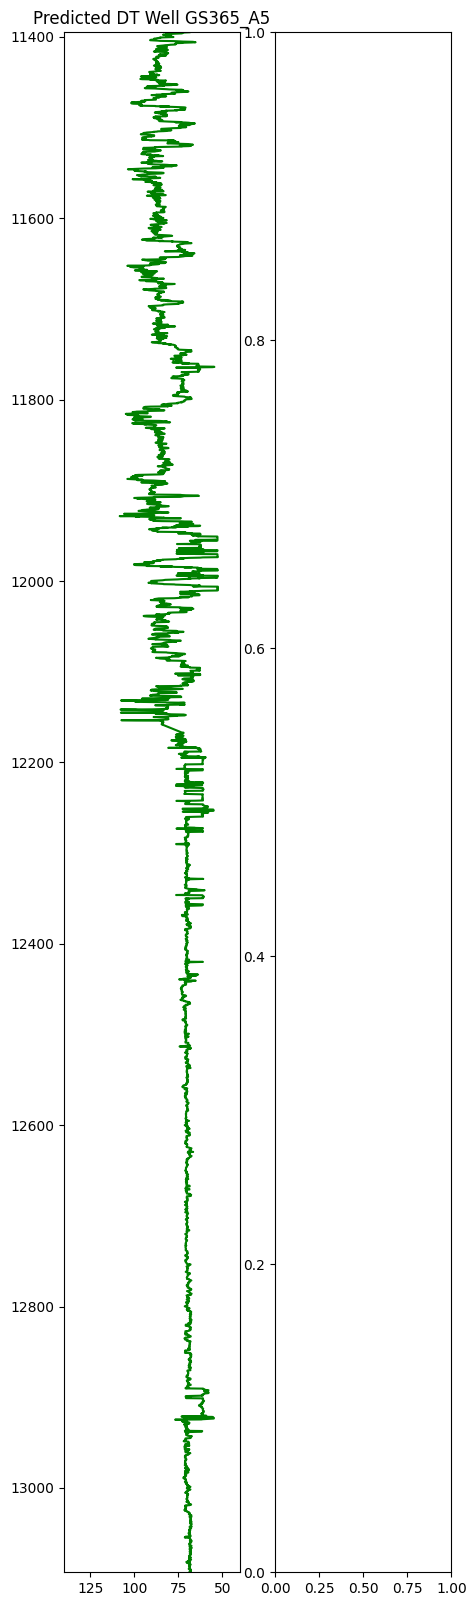

In [89]:
plt.figure(figsize=(5,20))

plt.subplot(1,2,1)
plt.plot(y_pred_blind_well, depth_blind_well, color='green')#,alpha=0.6

plt.ylim(max(depth_blind_well), min(depth_blind_well))

plt.xlim(140, 40)
plt.title('Predicted DT Well GS365_A5', size=12)

plt.subplot(1,2,2)
plt.plot(blind_well['DT'], depth_blind_well, color='blue')
plt.ylim(max(depth_blind_well), min(depth_blind_well))
plt.xlim(140, 40)
plt.title('DT Well GS365_A5', size=12)

plt.show()

In [ ]:
from matplotlib  import gridspec

Flagging Methods
1st Method : The difference between the predicted and actual is larger than the mean difference then add one standard of devation

2nd Method : if it's negative

3rd Method : if it's larger than mean + one standard of devation

In [ ]:
def error_flag(pred, actual, dev = 1.0, method = 1):

    flag = np.zeros(len(pred))
    err = np.abs(pred-actual)
    err_mean = np.mean(err)
    err_std = np.std(err)
    ss = np.sign(pred.diff().fillna(pred))
    ls = np.sign(actual.diff().fillna(actual))

    if method == 1:
        flag[np.where(err>(err_mean + (dev*err_std)))] = 1
    elif method == 2:      
        flag[np.where((ss + ls)==0 )]= 1
    elif method == 3:
        flag[np.where(np.logical_or(err>(err_mean + (dev*err_std)), (ss+ls)==0 ))]= 1
    return flag

In [ ]:
flag = error_flag(blind_well['predicted'], blind_well['DT'], 1,  1)

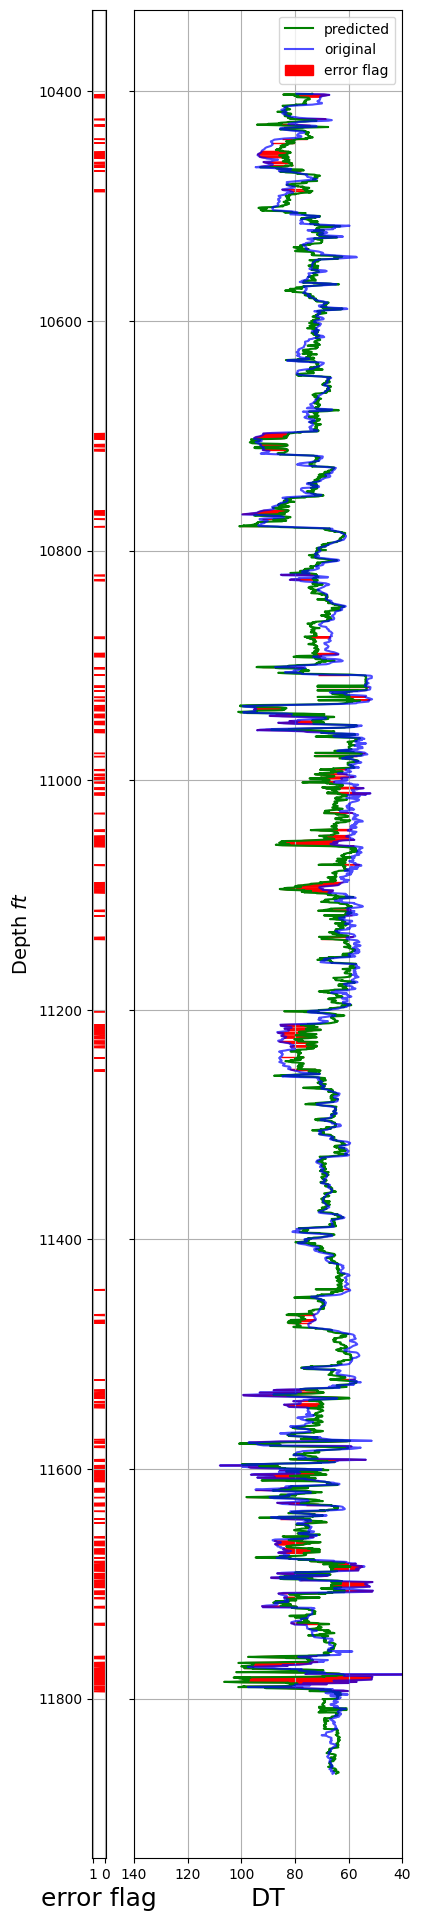

In [ ]:
fig = plt.figure(figsize=(4,24))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.2, 4]) 


ax = plt.subplot(gs[0])
ax.set_ylabel(r'Depth $ft$', size=14)
ax.fill_betweenx(depth_blind_well, flag, 0, color = 'r')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel('error flag', size=18)

ax.grid()

ax1 = plt.subplot(gs[1])
ax1.plot(y_pred_blind_well, depth_blind_well, 'Green', label='predicted', )
ax1.plot(blind_well['DT'], depth_blind_well, 'blue', label='original', alpha=0.7)

ax1.fill_betweenx(depth_blind_well, y_pred_blind_well,blind_well['DT'], where=flag==1, color = 'r', label='error flag')

# Do some plot annotations
#ax1.set_title('title here')
ax1.invert_yaxis()
ax1.set_yticklabels([])
ax1.set_xlabel('DT', size=18)
ax1.legend()
ax1.grid()

plt.xlim(140, 40)
plt.show()

## 05_Model Packing


In [ ]:
import pickle

# Save to file in the current working directory
pkl_filename = "spe_ml_model_final.pkl"


with open(pkl_filename, 'wb') as file:
    pickle.dump(pipeline, file)

In [24]:
import joblib
joblib.dump(pipeline, './sonic_prediction_model.pkl') 

['./sonic_prediction_model.pkl']

In [25]:
# load the model from disk
loaded_model = joblib.load('./sonic_prediction_model.pkl')
result = loaded_model.score(X_test, y_test)
print(result)

0.8885649667955157
